# Analisi dei Dati dei Turisti a Verona (2014-2022)

## Obiettivo
L'obiettivo di questa analisi è identificare i pattern di comportamento dei turisti che visitano Verona tra il 2014 e il 2022, utilizzando **algoritmi di clustering**.


## Dataset da scaricare per usare gli algoritmi
1. **Visite dal 2014 al 2022**: [link al dataset in github](https://github.com/Onda02/Clustering-turismo-verona/blob/main/dataset/data_POI_2014_to_2022.zip) (da decomprimere)
2. **Informazioni aggiuntive attrazioni**: [link al dataset in github](https://github.com/Onda02/Clustering-turismo-verona/blob/main/dataset/poi_info.csv)

## Importazione delle librerie necessarie


In [41]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import warnings
from datetime import datetime, time
from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages
from sklearn_extra.cluster import KMedoids
import Levenshtein
from multiprocessing import Pool, cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
from Levenshtein import distance
import multiprocessing as mp 
import sys
import h5py
import os
import gc
import time as t
from sklearn.metrics import pairwise_distances_argmin
import folium
from folium import PolyLine
import seaborn as sns
import random

# Creazione grafo rete stradale di verona
Da eseguire solo una volta

In [7]:
#Da eseguire solo una volta, poi si salvano i dati sul file Verona.graphml quindi di possono importare per velocizzare il calcolo
graph_area = ("Verona, Italy")
G = ox.graph_from_place(graph_area, network_type='walk') # definisce che ci si muove a piedi
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
# Salva il grafico su disco per riutilizzarlo
ox.save_graphml(G, "Verona.graphml")

# Esecuzione della classe Data
Questa classe contiene tutti i metodi necessari per eseguire i vari metodi di clutsering e per il salvataggio dei risultati

## Input per la creazione dell'oggetto:  
1. datapath: path del dataset in cui si parte avendo solo dati relativi a visite hanno fatto i turisti (rappresentati da un id_veroncard)
            
2. infopath: path delle informazioni aggiuntive sui poi (come la sua categoria ...)
            
3. dtype_dataoptions: dictionary che contiene il tipo delle colonne del dataset in datapath
        es: dtype_options = {'activation_date': str, 'id_vc': str, 'visit_timestamp' : str, 'profile_vc': str, 'poi' : int}
            
4. dtype_datainfo : dictionary che contiene il tipo delle colonne del datasat in info
        es: dtype_options = {'poi_id': int, 'poi_name': str, 'category_id' : int, 'category_name' : str, 'longitude' : float, 'latitude' : float }
   
5.  da poi_id_col a latitude_col abbiamo il nome delle colonne relative al dataset self.info che 
        rappresentano l'id del poi, il nome del poi, ..., la latitudine del poi

6. da id_vc_col a poi_col sono le colonne del dataset data

In [42]:
class Data:

    def __init__(self,datapath,infopath,dtype_dataoptions, dtype_infooptions,
                id_vc_col, timestamp_col, poi_col,
                poi_id_col, poi_name_col, category_id_col, category_name_col,longitude_col,latitude_col
                ):
        self.data = pd.read_csv(datapath, dtype=dtype_dataoptions)
        self.info = pd.read_csv(dataInfo_path, dtype = dtype_infooptions)
        
        
        #COLONNE INFO
        self.poi_id_col = poi_id_col
        self.poi_name_col = poi_name_col
        self.category_id_col = category_id_col
        self.category_name_col = category_name_col
        self.longitude_col = longitude_col
        self.latitude_col = latitude_col

        #COLONNE DATA
        self.id_vc_col = id_vc_col
        self.timestamp_col = timestamp_col
        self.poi_col = poi_col


        self.distance_cache = {}
        self.poi_map = {}
        
        self.G = ox.load_graphml("Verona.graphml") # da decommentare se si vuole caricare il grafo dal file precedentemente creato, commentare le righe prima

        #qua salvo la matrice risultato in cui ho i poi visitati intatti
        self.poiway_result = {}
        #qua salvo la matrice data in pasto all'algoritmo di kmeans quindi con le trasformazioni fatte ai poi
        self.poiway_matrix = {}
        self.best_k_foryear_poiway = {}
        self.best_value_foryear_poiway = {}
        
        #qua salvo la matrice risultato in cui ho i poi visitati intatti
        self.catway_result = {}
        #qua salvo la matrice data in pasto all'algoritmo di kmeans quindi con le trasformazioni fatte ai poi
        self.catway_matrix = {}
        self.best_k_foryear_catway = {}
        self.best_value_foryear_catway = {}

        #qua salvo la matrice delle distanze data in pasto al kmedoid
        self.levdistance_matrix = {}
        #qua salvo la matrice data in pasto al kmeans con le label calcolate dal kmedoid al posto dei poi
        self.levway_matrix = {}
        #qua salvo la matrice risultate finale coi poi intatti e coi risultati del clutser
        self.levway_result = {}
        #best in kmeans
        self.best_k_foryear_kmeans = {}
        self.best_value_foryear_kmeans= {}
        #best in kmedoid
        self.best_k_foryear_kmedoid= {}
        self.best_value_foryear_kmedoid= {}
        self.centroidIndex_methodA = {}

        #qua salvo la matrice delle distanze data in pasto al kmedoid
        self.methodB_matrix = {}
        #qua salvo la matrice risultate finale coi poi intatti e coi risultati del clutser
        self.methodB_result = {}
        #best in kmeans
        self.best_k_foryear_methodB_ = {}
        self.best_value_foryear_methodB_= {}
        self.centroidIndex_methodB = {}

        #id_veronacard	profilo	data_visita	ora_visita	sito_nome	poi

    def map_poiinformations(self):
        # Create a dictionary to map POIs to their respective attributes
        for index, row in self.info.iterrows():
            # Initialize poi_id before using it
            poi_id = row[self.poi_id_col]
            
            # Create a dictionary with initial poi information
            poi_info = {
                'poi_name': row[self.poi_name_col],
                'category_id': [],
                'category_name': [],
                'longitude': row[self.longitude_col],
                'latitude': row[self.latitude_col]
            }
            
            # Store the poi_info in the poi_map using poi_id as the key
            self.poi_map[poi_id] = poi_info

        # Map category_id and category_name to the correct POI
        for index, row in self.info.iterrows():
            poi_id = row[self.poi_id_col]
            self.poi_map[poi_id]['category_id'].append(row[self.category_id_col])
            self.poi_map[poi_id]['category_name'].append(row[self.category_name_col])
    
            
    
    def get_coordinates(self,poi_id):
      if poi_id in self.poi_map:
        poi_info = self.poi_map[poi_id]
        return poi_info[self.longitude_col], poi_info[self.latitude_col]
      else:
        print('ERRORE (get coordinates): poi non mappato')
        return None, None

    def get_category(self,poi_id):
      if poi_id in self.poi_map:
        poi_info = self.poi_map[poi_id]
        return poi_info[self.category_id_col]
      else:
        print(f'ERRORE (get category): poi {poi_id} non mappato')
        return None 

    

    def getDistance(self,lon_dest, lat_dest, lon_origin, lat_origin):
        origin_node = ox.nearest_nodes(self.G, lon_origin, lat_origin)
        destination_node = ox.nearest_nodes(self.G, lon_dest, lat_dest)
    
        distance_in_meters = nx.shortest_path_length(self.G, origin_node, destination_node, weight='length')
        return distance_in_meters 
        
    
    """
    # Pre-calcola le distanze tra tutti i POI
    poi_distances = {}
    for poi_id_origin, coord_origin in poi_coordinates.items():
        for poi_id_dest, coord_dest in poi_coordinates.items():
            poi_distances[(poi_id_origin, poi_id_dest)] = getDistance(coord_dest[0], coord_dest[1], coord_origin[0], coord_origin[1])
    """

    # Funzione per ottenere la distanza tra due POI
    def get_distance_cached(self, poi_id_origin, poi_id_dest):
        if (poi_id_origin, poi_id_dest) in self.distance_cache:
            return self.distance_cache[(poi_id_origin, poi_id_dest)]
        else:
            # Calculate distance using the getDistance method
            lon_origin, lat_origin = self.get_coordinates(poi_id_origin)
            lon_dest, lat_dest = self.get_coordinates(poi_id_dest)
            if lon_origin is None or lon_dest is None:
                return None
            distance = self.getDistance(lon_dest, lat_dest, lon_origin, lat_origin)
            # Save distance in the cache
            self.distance_cache[(poi_id_origin, poi_id_dest)] = distance
            return distance

    def calculate_time_slot(self,timestamp):
        if timestamp.time() < time(12,0):
            return 1  # Mattina
        elif timestamp.time() < time(14,0):
            return 2  # Pranzo
        elif timestamp.time() < time(18,0):
            return 3  # Pomeriggio
        else:
            return 4  # Sera

    
    #Category name * 1000 +poi, applichiamo questa formula in base al numero di poi che abbiamo
    def transform_value_poiway(self,poi):
      if(poi!=9000):
        #un poi potrebbe avere piu cat, in questo caso prendo solo l'ultimo inserito
        return self.get_category(poi)[-1] * 1000 + poi # Moltiplica la categoria per 1000 e aggiungi il numero del poi
      else:
        return 9000;
          
    # Per ogni poi ritorna la sua categoria mappata
    def transform_value_onlycatway(self,poi):
      if(poi!=9000):
        #un poi potrebbe avere piu cat, in questo caso prendo solo l'ultimo inserito
        return self.get_category(poi)[-1] 
      else:
        return 10;

    def calculate_silhouette_kmedoid(self, distance_matrix, k):
        # K-Medoids with precomputed distance matrix
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', init='k-medoids++', random_state=1000)
        labels = kmedoids.fit_predict(distance_matrix)
        silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
        return silhouette_avg
          
    def calculate_silhouette_kmeans(self,data, k):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=1000)
        labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        return silhouette_avg

    def find_optimal_clusters(self,data, year, tipocodifica, tipomatrice,method= 'A', max_clusters=20, n_jobs=2):
        """
            param 
            tipocodifica:
            0 = kmeans
            1 = kmedoid
            
            tipomatrice:
            0 = poiway
            1 = catway
            2 = levway
        """
        stringamatrice = ["poiway", "catway", "levway"]
        stringacodifica = ["kmeans" , "kmedoid"]
        K = range(2, max_clusters + 1)
    
        # Calcollo silhoette in parallelo
        if(tipocodifica==0):
            silhouette_scores = Parallel(n_jobs=n_jobs)(delayed(self.calculate_silhouette_kmeans)(data, k) for k in K)
        else:
           silhouette_scores = Parallel(n_jobs=n_jobs)(
            delayed(self.calculate_silhouette_kmedoid)(data, k) for k in K
        ) 
        score_copy = silhouette_scores.copy()
            
        best_value = 1
        
        while best_value>= 0.99:
            optimal_k = K[np.argmax(score_copy)]   
            best_value = round(max(score_copy),2)
            score_copy[np.argmax(score_copy)] = -1
            

        plt.figure(figsize=(10, 6))
        plt.plot(K, silhouette_scores, 'bo-')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Silhouette Score') 
        plt.title(f'Silhouette {stringamatrice[tipomatrice]} {stringacodifica[tipocodifica]} For Optimal k')
        plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
        plt.legend()
        plt.grid(True)
        plt.show

        if tipomatrice != 2:
            plt.savefig(f'./grafici/{stringamatrice[tipomatrice]}/{stringacodifica[tipocodifica]}/silhouettescore_{year}.png')
        else:
            plt.savefig(f'./grafici/{stringamatrice[tipomatrice]}/method{method}/{stringacodifica[tipocodifica]}/silhouettescore_{year}.png')
    
        return optimal_k, best_value
    def distanza_levenshtein(self, stringa1, stringa2):
        return distance(stringa1, stringa2)
    def calcola_distanza( self, lock,  dataset_finale , indice_inizio, indice_fine, numero_colonne, anno ):
    
        # --> Creo la sottomatrice la matrice <--
        ## Utilizzo uint ossia 1Byte di intero sensa segno: la distanza può essere al massimo 8*15 
        ## caratteri e quindi 120 < 2^8 ossia 120 < 256. Unsigned perchè tanto la distanza non
        ## può essere negativa. 
        ## La matrice calcola la distanza tra le righe "indice_inizio" ed "indice_fine" però 
        ## ogni processo crea la propria matrice, quindi se l'indice di partenza è 1000 nella
        ## matrice locale la posizione 1000 è da mappare in 0
        numero_righe = indice_fine - indice_inizio
        matrice_distanze = np.zeros(shape=(numero_righe, numero_colonne), dtype=np.uint16)
        distanze = {}
        ## Uso indice_inizio per accedere alla iesima riga dal dataset
        for i in range(indice_inizio, indice_fine):
            # --> Differenza tra questa iesmia e le restanti <--
            stringa_uno = dataset_finale['stringa'].iloc[i]
            
            # --> NB: come limite superiore del range metti "numero_colonne" perchè le colonne
            #         da scorrere sono "tutte"; se usassi indice_fine non scorrerei quindi tutte
            #         ma solo quelle comprese nel limite. Lo scrivo pk ho sbagliato sta cosa
            #         e infatti non mi uscivano i risultati corretti
            # INOLTRE la matrice è simmetrica quindi tutta la parte sotto la diagonale è deducibile 
            # guardando sopra la diagonale. Più che altro è che per come sto lavorando ora devo per 
            # forza fare così saddly
            for j in range(i+1, numero_colonne):
    
                # --> Estraggo la j-esima riga <--
                stringa_due = dataset_finale['stringa'].iloc[j]
                somma_distanza = 0
                somma_distanza = self.distanza_levenshtein(stringa_uno , stringa_due ) 
                ## Mappo la i posizione nella matrice che inizia da 0. Se sono alla riga
                ## 1001 e parto dall'indice 1000 allora sarebbe la riga 1 della matrice 
                ## quindi 1001 - 1000. La colonna non serve fare questo in quanto "costante"
                matrice_distanze[ i - indice_inizio , j ] = somma_distanza
                
                            
        # Salvo la matrice nel file dell'anno appositamente creato
        nome_dataset = str(indice_inizio) + '_' + str(indice_fine)
        with lock:
            with h5py.File(f'./matrici_di_distanza/matrice_anno_{anno}.hdf5', 'a') as f:
                    dset = f.create_dataset(f"{nome_dataset}", 
                                            data = matrice_distanze,
                                            compression='gzip',
                                            dtype=np.uint16
                                           )


    def calcola_distanza2( self, lock,  dataset_finale , kmeans_matrix, indice_inizio, indice_fine, numero_colonne, anno ):
    
        # --> Creo la sottomatrice la matrice <--
        ## Utilizzo uint ossia 1Byte di intero sensa segno: la distanza può essere al massimo 8*15 
        ## caratteri e quindi 120 < 2^8 ossia 120 < 256. Unsigned perchè tanto la distanza non
        ## può essere negativa. 
        ## La matrice calcola la distanza tra le righe "indice_inizio" ed "indice_fine" però 
        ## ogni processo crea la propria matrice, quindi se l'indice di partenza è 1000 nella
        ## matrice locale la posizione 1000 è da mappare in 0
        numero_righe = indice_fine - indice_inizio
        matrice_distanze = np.zeros(shape=(numero_righe, numero_colonne), dtype=np.uint16)
        distanze = {}

        ## Uso indice_inizio per accedere alla iesima riga dal dataset
        for i in range(indice_inizio, indice_fine):
            # --> Differenza tra questa iesmia e le restanti <--
            stringa_uno = dataset_finale['stringa'].iloc[i]
            
            # --> NB: come limite superiore del range metti "numero_colonne" perchè le colonne
            #         da scorrere sono "tutte"; se usassi indice_fine non scorrerei quindi tutte
            #         ma solo quelle comprese nel limite. Lo scrivo pk ho sbagliato sta cosa
            #         e infatti non mi uscivano i risultati corretti
            # INOLTRE la matrice è simmetrica quindi tutta la parte sotto la diagonale è deducibile 
            # guardando sopra la diagonale. Più che altro è che per come sto lavorando ora devo per 
            # forza fare così saddly
            for j in range(i+1, numero_colonne):
    
                # --> Estraggo la j-esima riga <--
                stringa_due = dataset_finale['stringa'].iloc[j]
                somma_distanza = 0
                somma_distanza = self.distanza_levenshtein(stringa_uno , stringa_due )
                duration_i = kmeans_matrix.iloc[i]['duration']
                duration_j = kmeans_matrix.iloc[j]['duration']
                time_slot_i = kmeans_matrix.iloc[i]['time_slot']
                time_slot_j = kmeans_matrix.iloc[j]['time_slot']
                length_i = kmeans_matrix.iloc[i]['length'] 
                length_j = kmeans_matrix.iloc[j]['length'] 
                
                euc_duration = max(length_i, length_j) - min(length_i, length_j)
                euc_length = max(time_slot_i, time_slot_j) - min(time_slot_i, time_slot_j)
                euc_time_slot = max(time_slot_i, time_slot_j) - min(time_slot_i, time_slot_j)
                """
                euc_duration = abs(kmeans_matrix.iloc[i]['duration']- kmeans_matrix.iloc[j]['duration'])
                euc_length = abs(kmeans_matrix.iloc[i]['length']- kmeans_matrix.iloc[j]['length'])
                euc_time_slot = abs(kmeans_matrix.iloc[i]['time_slot']- kmeans_matrix.iloc[j]['time_slot'])
                """
                somma_distanza += euc_duration + euc_time_slot + euc_length
                ## Mappo la i posizione nella matrice che inizia da 0. Se sono alla riga
                ## 1001 e parto dall'indice 1000 allora sarebbe la riga 1 della matrice 
                ## quindi 1001 - 1000. La colonna non serve fare questo in quanto "costante"
                matrice_distanze[ i - indice_inizio , j ] = somma_distanza
        
                            
        # Salvo la matrice nel file dell'anno appositamente creato
        nome_dataset = str(indice_inizio) + '_' + str(indice_fine)
        with lock:
            with h5py.File(f'./matrici_di_distanza2/matrice_anno_{anno}.hdf5', 'a') as f:
                    dset = f.create_dataset(f"{nome_dataset}", 
                                            data = matrice_distanze,
                                            compression='gzip',
                                            dtype=np.uint16
                                           )
                   
    def save_zipfile(self,file_path,dataset_name, matrice):
        with h5py.File(file_path, 'w') as f:  # 'w' sta per write, crea un nuovo file o sovrascrive esistente
            # Crea un dataset con il nome specificato e salva la matrice
            f.create_dataset(dataset_name, data=matrice, compression='gzip', dtype=np.uint16)

        # Funzione per calcolare il percorso più breve tra due coordinate
    def get_shortest_path(self,lon_dest, lat_dest, lon_origin, lat_origin):
        origin_node = ox.nearest_nodes(self.G, lon_origin, lat_origin)
        destination_node = ox.nearest_nodes(self.G, lon_dest, lat_dest)
        path = nx.shortest_path(self.G, origin_node, destination_node, weight='length')
        return path

    def delete_files(self):
        # Percorso della directory
        directory = 'matrici_di_distanza'
        
        # Controlla se la directory esiste
        if os.path.isdir(directory):
            # Cancella tutti i file nella directory
            for filename in os.listdir(directory):
                file_path = os.path.join(directory, filename)
                # Controlla se è un file (non una directory)
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"File {file_path} cancellato.")
        else:
            print(f"La directory {directory} non esiste.")
            # Funzione per ottenere la trasparenza in base alla frequenza dei percorsi
            def get_transparency(self,count, max_count):
                if max_count == 0:
                    return 0.5
                return 0.1 + 0.9 * (count / max_count)
            
    def process_cluster(self,cluster_label, centroids):
        cluster_data = centroids[centroids['clusters_label'] == cluster_label]
    
        # Crea una mappa centrata su Verona
        cluster_map = folium.Map(location=[45.4384, 10.9916], zoom_start=13)
    
        # Dizionario per tenere traccia dei percorsi tra i marker
        path_cache = {}
        path_counts = {}
    
        # Inizializzazione dei set di marker
        first_viewed = set()
        last_viewed = set()
        all_viewed = set()
    
        # Mappatura dei colori per i cluster
        colors = sns.color_palette("hsv", len(centroids['clusters_label'].unique())).as_hex()
    
        # Elaborazione dei dati
        for _, row in cluster_data.iterrows():
            path = []
            
            # Mi salvo in path il percorso della riga corrente
            for i in range(15):  # Assumendo 15 colonne di attrazioni
                attr = row.get(f'attrazione{i}', 9000)
                if attr == 9000:
                    break

                if attr in self.poi_map:
                    attr_info = self.poi_map[attr]
                    path.append((attr_info['latitude'], attr_info['longitude']))
                    all_viewed.add(attr)
                else:
                    print(f"Attrazione {attr} non trovata in poi_map")
    
            if len(path) < 2:
                continue
    
            for j in range(len(path) - 1):
                start = path[j]
                end = path[j + 1]
                segment = (start, end)
                if segment not in path_cache:
                    path_cache[segment] = self.get_shortest_path(end[1], end[0], start[1], start[0])
    
                path_nodes = path_cache[segment]
                path_coords = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in path_nodes]
    
                # Contare i segmenti
                if segment not in path_counts:
                    path_counts[segment] = 0
                path_counts[segment] += 1
    
        # Determinare la massima frequenza per la trasparenza
        max_count = max(path_counts.values()) if path_counts else 1
    
        # Disegnare i percorsi sulla mappa con trasparenza
        for segment, count in path_counts.items():
            transparency = self.get_transparency(count, max_count)
            path_nodes = path_cache[segment]
            path_coords = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in path_nodes]
            folium.PolyLine(path_coords, color=colors[cluster_label], weight=3.5, opacity=transparency).add_to(cluster_map)
    
        # Identificazione dei marker
        first_viewed = set()
        last_viewed = set()
        all_viewed = set()
        
        # Per capire i marker visitati per primi o per ultimi o entrambi
        for _, row in cluster_data.iterrows():
            for i in range(15):  # Assumendo 15 colonne di attrazioni
                attr = row.get(f'attrazione{i}', 9000)
                
                if attr == 9000:
                    break
                    
                if attr in self.poi_map:
                    if i == 0:
                        first_viewed.add(attr)
                    if i == len(row) - 1 or row.get(f'attrazione{i + 1}', 9000) == 9000:
                        last_viewed.add(attr)
                    all_viewed.add(attr)
    
        # Aggiungi marker alla mappa
        for poi_id, attr_info in self.poi_map.items():
            colore = 'gray'
            if poi_id in all_viewed:
                if poi_id in first_viewed and poi_id in last_viewed:
                    colore = 'orange'  # Primo e ultimo
                elif poi_id in first_viewed:
                    colore = 'blue'  # Solo primo
                elif poi_id in last_viewed:
                    colore = 'red'  # Solo ultimo
                else:
                    colore = 'green' #visto almeno una volta
    
            folium.Marker(
                location=[attr_info['latitude'], attr_info['longitude']],
                popup=f"Attrazione {poi_id}: {attr_info['poi_name']}",
                icon=folium.Icon(color=colore)
            ).add_to(cluster_map)
            
        legend_html = '''
        <div style="position: fixed;
            padding: 25px;
            border-radius: 25px;
            bottom: 50px; 
            left: 50px; 
            width: 290px; 
            height: 250px; 
            background-color: #f9f9f9; 
            z-index: 9999; 
            font-size: 14px; 
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); 
            color: #333;">
            <b style="display: block; margin-bottom: 12px; font-size: 16px; color: #222;">Legenda marker:</b>
            
            <div style="margin-bottom: 8px; line-height: 1.5;">
                <i class="fa fa-map-marker fa-2x" style="color: orange; vertical-align: middle;"></i>&nbsp;Sia per primo che per ultimo
            </div>
            <div style="margin-bottom: 8px; line-height: 1.5;">
                <i class="fa fa-map-marker fa-2x" style="color: blue; vertical-align: middle;"></i>&nbsp;Per primo
            </div>
            <div style="margin-bottom: 8px; line-height: 1.5;">
                <i class="fa fa-map-marker fa-2x" style="color: red; vertical-align: middle;"></i>&nbsp;Per ultimo
            </div>
            <div style="margin-bottom: 8px; line-height: 1.5;">
                <i class="fa fa-map-marker fa-2x" style="color: green; vertical-align: middle;"></i>&nbsp;Nè primo nè ultimo
            </div>
            <div style="line-height: 1.5;">
                <i class="fa fa-map-marker fa-2x" style="color: gray; vertical-align: middle;"></i>&nbsp;Mai Visualizzato
            </div>lass="fa fa-map-marker fa-2x" style="color: gray; vertical-align: middle;"></i>&nbsp;Mai Visualizzato
            </div>
        </div>
        '''
        cluster_map.get_root().html.add_child(folium.Element(legend_html))
        legend_html2 = '''
         <div style="position: fixed;
         padding: 20px;
         border-radius: 25px;
         bottom: 50px; right: 50px; width: 200px; height: 180px; 
         background-color: white; z-index:9999; font-size:14px;">
         <b>Legenda percorsi:</b><br>
         <i class="fa fa-map-marker fa-2x" style="color:gray"></i>&nbsp;Todo<br>
         </div>
         '''
        #cluster_map.get_root().html.add_child(folium.Element(legend_html2))
    
        # Salva la mappa
        cluster_map.save(f'cluster_map_{cluster_label}.html')

    def process_cluster2(self,clusters, centroids, tracks, year,durate_somma, durate_min, durate_max,num_tracce, flag_method = 'A'):

        # Crea una mappa centrata su Verona
        cluster_map = folium.Map(location=[45.4384, 10.9916], zoom_start=13)
    
        # Dizionario per tenere traccia dei percorsi tra i marker
        path_cache = {}
        path_counts = {}
        path_type = {}

         # Identificazione dei marker
        first_viewed = set()
        last_viewed = set()
        all_viewed = set()
        
        # Mappatura dei colori per i cluster
        colors = sns.color_palette("hsv", len(centroids['clusters_label'].unique())).as_hex()
        for cluster_label in clusters:
            cluster_data = centroids[centroids['clusters_label'] == cluster_label]    
        
            # Elaborazione dei dati
            for _, row in cluster_data.iterrows():
                path = []
                
                # Mi salvo in path il percorso della riga corrente
                for i in range(15):  # Assumendo 15 colonne di attrazioni
                    attr = row.get(f'attrazione{i}', 9000)
                    if attr == 9000:
                        break
        
                    if attr in self.poi_map:
                        attr_info = self.poi_map[attr]
                        path.append((attr_info['latitude'], attr_info['longitude']))
                        all_viewed.add(attr)
                    else:
                        print(f"Attrazione {attr} non trovata in poi_map")
        
                if len(path) < 2:
                    continue
        
                for j in range(len(path) - 1):
                    start = path[j]
                    end = path[j + 1]
                    segment = (start, end)
                    if segment not in path_cache:
                        path_cache[segment] = self.get_shortest_path(end[1], end[0], start[1], start[0])
        
                    path_nodes = path_cache[segment]
                    path_coords = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in path_nodes]
        
                    # Contare i segmenti
                    if segment not in path_type:
                        path_type[segment] = []
                    path_type[segment].append(cluster_label)
            
      
  
    
        # Disegnare i percorsi sulla mappa con trasparenza
        for segment, type_list in path_type.items():
            transparency = 1
            path_nodes = path_cache[segment]
            path_coords = [(self.G.nodes[node]['y'], self.G.nodes[node]['x']) for node in path_nodes]
            # Loop su ogni tipo nella type_list
            for index, type in enumerate(type_list):
        
                # Applica l'offset solo all'asse y per spostare leggermente le linee
                offset_coords = [(lat, lon) for lat, lon in path_coords]
        
                # Aggiungi la linea al cluster_map con le coordinate spostate
                folium.PolyLine(
                    offset_coords, 
                    color=colors[type], 
                    weight=5, 
                    opacity=transparency, 
                ).add_to(cluster_map)
                
        # coloro i marker di tutte le tracce
        
        for cluster_label in clusters:
            
            cluster_data = tracks[tracks['clusters_label'] == cluster_label] 
            # Per capire i marker visitati per primi o per ultimi o entrambi
            for _, row in cluster_data.iterrows():
                for i in range(15):  # Assumendo 15 colonne di attrazioni
                    attr = row.get(f'attrazione{i}', 9000)
                    
                    if attr == 9000:
                        break
                        
                    if attr in self.poi_map:
                        if i == 0:
                            first_viewed.add(attr)
                        if i == len(row) - 1 or row.get(f'attrazione{i + 1}', 9000) == 9000:
                            last_viewed.add(attr)
                        all_viewed.add(attr)

        first_viewed_centroids = set()
        last_viewed_centroids = set()
        all_viewed_centroids = set()
        for cluster_label in clusters:
            
            cluster_data = centroids [centroids['clusters_label'] == cluster_label] 
            # Per capire i marker visitati per primi o per ultimi o entrambi
            for _, row in cluster_data.iterrows():
                for i in range(15):  # Assumendo 15 colonne di attrazioni
                    attr = row.get(f'attrazione{i}', 9000)
                    
                    if attr == 9000:
                        break
                        
                    if attr in self.poi_map:
                        if i == 0:
                            first_viewed_centroids.add(attr)
                        if i == len(row) - 1 or row.get(f'attrazione{i + 1}', 9000) == 9000:
                            last_viewed_centroids.add(attr)
                        all_viewed_centroids.add(attr)

        
        # Aggiungi marker alla mappa
        for poi_id, attr_info in self.poi_map.items():
            colore = 'gray'
            if poi_id in all_viewed:
                colore = 'green'
            if poi_id in all_viewed_centroids:
                colore = 'darkblue'
            """
            if poi_id in all_viewed:
                if poi_id in first_viewed and poi_id in last_viewed:
                    colore = 'orange'  # Primo e ultimo
                    print("BOTH VIEWED")
                elif poi_id in first_viewed:
                    colore = 'white'  # Solo primo
                    print("FIRST VIEWED")
                elif poi_id in last_viewed:
                    print("LAST VIEWED")
                    colore = 'beige'  # Solo ultimo
                else:
                    print("ONLY ONE VIEWD")
                    colore = 'green' #visto almeno una volta
            # PER IL CENTROIDE HA PIU IMPORTANZA 
            if poi_id in all_viewed:
                if poi_id in first_viewed_centroids and poi_id in last_viewed_centroids:
                    colore = 'purple'  # Primo e ultimo
                    print("BOTH VIEWED")
                elif poi_id in first_viewed_centroids:
                    colore = 'darkblue'  # Solo primo
                    print("FIRST VIEWED")
                elif poi_id in last_viewed_centroids:
                    print("LAST VIEWED")
                    colore = 'red'  # Solo ultimo
            """
            
            folium.Marker(
                location=[attr_info['latitude'], attr_info['longitude']],
                popup=f"Attrazione {poi_id}: {attr_info['poi_name']}",
                icon=folium.Icon(color=colore)
            ).add_to(cluster_map)
                
        legend_html = '''
        <div style="position: fixed;
            padding: 10px;
            border-radius: 10px;
            bottom: 50px; 
            left: 50px; 
            width: 250px; 
            height: 150px; 
            background-color: #f9f9f9; 
            z-index: 9999; 
            font-size: 12px; 
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); 
            color: #333;">

            <b style="display: block; margin-bottom: 8px; font-size: 14px; color: #222;">Legenda marker:</b>
            
            <div style="margin-bottom: 6px; line-height: 1.3;">
                <i class="fa fa-map-marker fa-lg" style="color: green; vertical-align: middle;"></i>&nbsp;Visualizzati da tracce appartenenti al centroide
            </div>
            <div style="margin-bottom: 6px; line-height: 1.3;">
                <i class="fa fa-map-marker fa-lg" style="color: blue; vertical-align: middle;"></i>&nbsp;Visualizzati solo dalla traccia del centroide
            </div>
            <div style="line-height: 1.3;">
                <i class="fa fa-map-marker fa-lg" style="color: gray; vertical-align: middle;"></i>&nbsp;Mai visualizzati
            </div>
        </div>

         '''
        cluster_map.get_root().html.add_child(folium.Element(legend_html))
        
        legend_html2 = f'''
         <div style="position: fixed;
         padding: 20px;
         border-radius: 25px;
         bottom: 50px; right: 50px; width: 250px; height: 180px; 
         background-color: white; z-index:9999; font-size:14px; line-height: 1.3;">
         <b style="margin-bottom: 3px; display: block;">Legenda centroide {clusters[0]}:</b><br>
         <span style="margin-bottom: 2px; display: block;">Durata centroide: {durate_somma} mezze ore</span>
         <span style="margin-bottom: 2px; display: block;">Durata minima: {durate_min} mezze ore</span>
         <span style="margin-bottom: 2px; display: block;">Durata massima: {durate_max} mezze ore</span>
         <span style="display: block;">Tracce totali: {num_tracce}</span>
         
         </div>
         '''
        cluster_map.get_root().html.add_child(folium.Element(legend_html2))
        
        # Salva la mappa
        if flag_method == 'A':
            cluster_map.save(f'./grafici/levway/method{flag_method}/kmeans/cluster{clusters[0]}_map_{year}.html')
        else:
            cluster_map.save(f'./grafici/levway/method{flag_method}/kmedoid/cluster{clusters[0]}_map_{year}.html')
        cluster_map
       
    def transform_data_forencoding(self,transform_way):
        self.data[self.timestamp_col] = pd.to_datetime(self.data[self.timestamp_col])
        maxPoiVisited = max(self.data.groupby(self.id_vc_col)[self.poi_col].apply(list).apply(len))
        # Trova l'anno minimo e massimo nei dati
        year = pd.to_datetime(self.data[self.timestamp_col]).dt.year
        min_year = year.min()
        max_year = year.max()
        warnings.filterwarnings("ignore")
        #for year in range(min_year,max_year+1):
        for year in range(min_year,max_year+1):
            data_thisyear = self.data[self.data[self.timestamp_col].dt.year == year]           
            if data_thisyear.empty:
                continue
      
            data_thisyear = data_thisyear.sort_values(by=self.timestamp_col)
            
            # Raggruppo i dati per id_vc e per ogni id_vc ho la lista di poi visitati e di timestamp
            grouped = data_thisyear.groupby(self.id_vc_col, as_index=False).apply(
                lambda x: pd.Series({
                    self.poi_col: x[self.poi_col].tolist(),
                    self.timestamp_col: x[self.timestamp_col].tolist()
                })
            ).reset_index(drop=True)
                                                                                
                
            for index,row in grouped.iterrows():
                
                first_timestamp = row[self.timestamp_col][0]
                last_timestamp = row[self.timestamp_col][-1]
                #trovo durata
                duration = int((last_timestamp - first_timestamp).total_seconds()/ 60)
                duration = np.uint16(round(duration/30))
                #trovo time slot
                time_slot = np.uint8(self.calculate_time_slot(first_timestamp))
                #trovo distanza percorsa
                total_distance = 0
                for i in range(len(row[self.poi_col]) - 1):
                    poi_id_origin = row[self.poi_col][i]
                    poi_id_dest = row[self.poi_col][i + 1]
                    total_distance += self.get_distance_cached(poi_id_origin, poi_id_dest)
                    
                total_distance = round(total_distance / 50) * 50  
                total_distance = np.float16(total_distance/1000)
                row[self.poi_col] += [9000] * (maxPoiVisited-len(row[self.poi_col]))
               
                
                grouped.at[index, 'duration'] = duration
                grouped.at[index, 'time_slot'] = time_slot
                grouped.at[index, 'length'] = total_distance
            
            grouped['duration'] = grouped['duration'].astype('uint16')  # Converte la colonna a float16            
            grouped['time_slot'] = grouped['time_slot'].astype('uint8')  # Converte la colonna a float16    
            grouped['length'] = grouped['length'].astype('float16')  # Converte la colonna a float16    
            grouped.drop(columns=self.timestamp_col, inplace = True)
    
            # espande la lista poi (inizialmente rappresentata da una colonna) in 
            # tante colonne quanti sono i poi e la assegna a expanded_poi
            expanded_poi = grouped[self.poi_col].apply(pd.Series)
            expanded_poi = expanded_poi.astype('uint16')
            expanded_poi.columns = [f'attrazione{i}' for i in range(maxPoiVisited)]
            
            result = pd.concat([grouped, expanded_poi], axis = 1)
            result.drop(columns = [self.poi_col], inplace = True)
            # li metto nell'ordine corretto
            # Ordina le colonne nel DataFrame risultante
            attrazione_columns = [f'attrazione{i}' for i in range(maxPoiVisited)]
            desired_order = ['id_vc'] + attrazione_columns + ['duration','time_slot','length']
            result = result[desired_order]

            kmeans_matrix =result.copy()
           
            i =0
            if transform_way == 0:
                 #applico formula ai poi in una matrice copiata, in modo che quella originale rimanga intatta
                for col in attrazione_columns:
                    kmeans_matrix[col] = kmeans_matrix[col].apply(self.transform_value_poiway)

                kmeans_matrix= kmeans_matrix.drop(self.id_vc_col, axis=1).values
                
                print(f"{year} calculating silhoette")
                best_k, best_value = self.find_optimal_clusters(kmeans_matrix, year, 0, 0)
                print(f"{year} finish silhoette")
                              
                kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init='auto', random_state=1000)
                clusters = kmeans.fit_predict(kmeans_matrix)
                result['clusters_label'] = clusters
                # SALVATAGGIO ATTRIBUTI OGGETTO
                self.poiway_result[year] = result.copy()
                self.poiway_matrix[year] = kmeans_matrix.copy()
                self.best_k_foryear_poiway[year] = best_k
                self.best_value_foryear_poiway[year] = best_value
                
                #SALVATAGGIO FILE
                result.to_csv(f"./matrici/poiway/kmeansResult_{year}.csv", index=False) 
                if(year == max_year+1):
                    self.best_k_foryear_poiway.to_csv(f"./matrici/poiway/bestClusterNumber", index = False)
                    self.best_value_foryear_poiway.to_csv(f"./matrici/poiway/bestValue", index = False)

                
            elif transform_way == 1:
                #applico formula ai poi in una matrice copiata, in modo che quella originale rimanga intatta
                for col in attrazione_columns:
                    kmeans_matrix[col] = kmeans_matrix[col].apply(self.transform_value_onlycatway)

                kmeans_matrix= kmeans_matrix.drop(self.id_vc_col, axis=1).values
                
                print(f"{year} calculating silhoette")
                best_k, best_value = self.find_optimal_clusters(kmeans_matrix, year, 0, 1)
                print(f"{year} finish silhoette")    
                kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init='auto', random_state=1000)
                clusters = kmeans.fit_predict(kmeans_matrix)
                result['clusters_label'] = clusters

                # SALVATAGGIO ATTRIBUTI OGGETTO
                self.catway_result[year] = result.copy()
                self.catway_matrix[year] = kmeans_matrix.copy()
                self.best_k_foryear_catway[year] = best_k
                self.best_value_foryear_catway[year] = best_value
                #SALVATAGGIO FILE
                result.to_csv(f"./matrici/catway/kmeansMatrix_{year}.csv", index=False) 
                if(year == max_year+1):
                    self.best_k_foryear_catway.to_csv(f"./matrici/catway/bestClusterNumber", index = False)
                    self.best_value_foryear_catway.to_csv(f"./matrici/catway/bestValue", index = False)
                       
            elif transform_way == 2:      
                
                lev_distance_strings =[]
                string_alreadyseen = {}
                for index, row in kmeans_matrix.iterrows():
                    finalstring = ""
                    for col in attrazione_columns:

                        catstring = "0000000000000000000000000"
                        if int(row[col]) == 9000:
                            unionstring = "#########################"
                        else:
                            
                            cat = self.get_category(int(row[col]))
                            
                            for el in cat:
                                el = el-1
                                # Questo perchè manca la categoria 3
                                if el<=2:
                            
                                    catstring = catstring[:(el)*5] + '11111' + catstring[(el+1)*5:]
                                else:
                                    catstring = catstring[:(el-1)*5] + '11111' + catstring[(el)*5:]
                            poistring = str(row[col]).zfill(3)
                            unionstring = catstring + poistring

                    
                        finalstring = finalstring + unionstring
            
                    if finalstring in string_alreadyseen:
                        string_alreadyseen[finalstring].append(index)
                    else:
                        string_alreadyseen[finalstring] = [index]
                        
                    n = len(string_alreadyseen[finalstring])

                    if n<=1:
                        lev_distance_strings.append(finalstring)
                        
                # ricerca del index nel dictionary
                # print((f"Len: {len(lev_distance_strings)} \n" ))
                
                directory = './matrici_di_distanza/'
                if not os.path.exists(directory):
                    os.makedirs(directory)
                
                dataset_finale = pd.DataFrame(lev_distance_strings, columns=["stringa"])
                dataset_finale.to_csv("dataset_finale.csv",index=False)
                
                n = dataset_finale.shape[0]
                lock = mp.Lock()
                threads = 20

                step = n // threads

                processi = []
                
                start_time = t.time()


                for thread in range(threads):
                    indice_riga_inizio = step*thread
                    if (thread+1) == threads:
                        indice_riga_fine = n
                    else: 
                        indice_riga_fine = indice_riga_inizio+step
                    p = mp.Process(target = self.calcola_distanza, args = (
                        lock,dataset_finale,indice_riga_inizio,indice_riga_fine,
                        n, year))

                    p.start()
                    processi.append(p) 
                    
                for processo in processi:
                    processo.join()
                    

                
                
                end_time = t.time()

                # Definisci il percorso del file e l'anno
                # Percorso del file HDF5
                file_path = f'./matrici_di_distanza/matrice_anno_{year}.hdf5'
                
                # Dizionario per memorizzare le matrici con i loro indici di inizio
                matrici = []
                
                # Apri il file HDF5 in modalità lettura
                with h5py.File(file_path, 'r') as f:
                    # Leggi i nomi dei dataset (es. '1000_2000', '2000_3000', ...)
                    dataset_names = list(f.keys())
                    
                    # Estrai gli indici di inizio e fine dai nomi dei dataset e ordina
                    for name in dataset_names:
                        # Estrarre gli indici di inizio e fine dal nome
                        # Es. nome_dataset = '1000_2000'
                        indice_inizio, indice_fine = map(int, name.split('_'))
                        
                        # Carica la matrice e aggiungila alla lista con gli indici
                        matrice = f[name][:]
                        matrici.append((indice_inizio, indice_fine, matrice))
                        #print(f"inizio : {indice_inizio}, fine: {indice_fine}, matrice : {matrice}")
                
                # Ordina le matrici in base agli indici di inizio
                matrici.sort(key=lambda x: x[0])  # Ordina in base al primo indice (indice_inizio)
                
                matrice_finale = np.concatenate([matrice[2] for matrice in matrici], axis=0)
                matrice_trasposta = matrice_finale.T
                
                # Calcola la somma della matrice originale con la sua trasposta
                self.levdistance_matrix[year] = matrice_finale + matrice_trasposta


                best_k_kmedoid, best_value_kmedoid = self.find_optimal_clusters(self.levdistance_matrix.get(year), year, 1, 2)

                #TODO silhouet
                kmedoids = KMedoids(n_clusters = best_k_kmedoid, metric = 'precomputed', random_state = 1000)
                clusters = kmedoids.fit_predict(self.levdistance_matrix.get(year))
                #kmeans_matrix = np.insert(kmeans_matrix, 1, clusters, axis=1)
                
                
                kmeans_matrix= kmeans_matrix.drop(self.id_vc_col, axis=1)
                for col in attrazione_columns:
                    kmeans_matrix = kmeans_matrix.drop([col], axis=1)

                nrighe = kmeans_matrix.shape[0]
                zeri = np.zeros(nrighe)
                kmeans_matrix = np.insert(kmeans_matrix, 0, zeri, axis=1)
                
                kmeans_matrix.astype(np.float16)

                #inserisco i valori nella matrice originale    
                j = 0
                for string,index in string_alreadyseen.items():
                    
                    for ind in index: 
                        kmeans_matrix[ind][0] = clusters[j]
                    j = j+1
                     
                print(f"{year} calculating silhoette")
                best_k, best_value = self.find_optimal_clusters(kmeans_matrix, year, 0,2)
                print(f"{year} finish silhoette")
        
                
                kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init='auto', random_state=1000)
                clusters = kmeans.fit_predict(kmeans_matrix)  
                

                   
                result['clusters_label'] = clusters
         
                centroids = kmeans.cluster_centers_ 
                # Trova gli indici delle tuple più vicine ai centroidi
                closest_indices = pairwise_distances_argmin(centroids, kmeans_matrix)
                # Recupera le tuple più vicine dai dati in risultato in cui sono presenti i poi  
                closest_tuples = result.iloc[closest_indices]

                  
                """
                for cluster in clusters:
                    self.process_cluster(cluster, closest_tuples)"""
                """
                print(f"Clusters: {clusters}\n closest_tuples :{closest_tuples}")
                self.process_cluster2(list(set(clusters)), closest_tuples, year)
                """
                durate_min = []
                durate_max = []
                num_tracce = []
                for i in range(len(list(set(clusters)))):
                    dati = result[result['clusters_label']==i]
                    durata_min = min(dati['duration'])
                    durata_max = max(dati['duration'])
                    n = len(dati)
                    durate_min.append(durata_min)
                    durate_max.append(durata_max)
                    num_tracce.append(n)

                print(f' min: {durate_min} max: {durate_max} num_tracce{num_tracce}')
                # faccio cosi perchè inizialmente avevo fatto che processavo tutti i cluster contemporaneamente
                # adesso abbiamo cambiato e gli mando una lista con un elemento per non cambiare tutto il codice è uguale
                """
                for cluster in list(set(clusters)):    
                    clust = [cluster]
                    durata = result[cluster]
                    #prima mandavo list(set(clusters)) al posto di clust
                    self.process_cluster2(clust, result.iloc[closest_indices], year,durate_somma[cluster], durate_min[cluster], durate_max[cluster],num_tracce[cluster], flag_method= 'A')
                """
                for index in closest_indices:
                    # cluster è una lista perchè inizialmente pensavo di elaborare tutti i cluster insieme
                    cluster = result.iloc[index]['clusters_label']
                    durata = result.iloc[index]['duration']
                    #prima mandavo list(set(clusters)) al posto di clust
                    self.process_cluster2([cluster], result.iloc[closest_indices], result, year,durata, durate_min[cluster], durate_max[cluster],num_tracce[cluster], flag_method= 'A')
                
                # SALVATAGGIO ATTRIBUTI OGGETTO
                self.centroidIndex_methodA[year] = closest_indices.copy()
                self.levway_result[year] = result.copy()
                self.levway_matrix[year] = kmeans_matrix.copy()
                self.best_k_foryear_kmeans[year] = best_k
                self.best_value_foryear_kmeans  = best_value_kmedoid
                self.best_k_foryear_kmedoid[year] = best_k_kmedoid
                self.best_value_foryear_kmedoid[year] = best_value_kmedoid

                #SALVATAGGIO FILE 
                # !!!!!!! METTI METHODA/ NEL PRIMO
                self.save_zipfile(f'./matrici/levway/kmedoidMatrix_{year}.hdf5', 'levdistance_matrix',self.levdistance_matrix.get(year))
                result.to_csv(f"./matrici/levway/methodA/kmeansResult_{year}.csv", index=False)
                np.savetxt(f"./matrici/levway/methodA/kmeansMatrix_{year}.csv", kmeans_matrix, delimiter=',', fmt='%f')
                #MATRICE DELLE DISTANCE TROPPO PESANTE LA SALVO COMPRESSA, USANDO QUESTO METODO
                
                
                   
                if(year == max_year):
                    df_best_k_foryear_kmeans = pd.DataFrame.from_dict(self.best_k_foryear_kmeans, orient='index') 
                    df_best_value_foryear_kmeans = pd.Series(self.best_value_foryear_kmeans).to_frame()       
                    df_best_k_foryear_kmedoid = pd.DataFrame.from_dict(self.best_k_foryear_kmedoid, orient='index') 
                    df_best_value_foryear_kmedoid = pd.Series(self.best_value_foryear_kmedoid).to_frame()
                    df_centroidIndex_methodA = pd.DataFrame.from_dict(self.centroidIndex_methodA, orient='index') 
                    df_centroidIndex_methodA.to_csv(f"./matrici/levway/methodA/centroidIndex.csv", index =True)
                    df_best_k_foryear_kmeans.to_csv(f"./matrici/levway/methodA/bestClusterNumberKmeans.csv", index =True)
                    df_best_value_foryear_kmeans.to_csv(f"./matrici/levway/methodA/bestValueKmeans.csv", index =True)
                    df_best_k_foryear_kmedoid.to_csv(f"./matrici/levway/methodA/bestClusterNumberKmedoid.csv", index =True)
                    df_best_value_foryear_kmedoid.to_csv(f"./matrici/levway/methodA/bestValueNumberKmedoid.csv", index =True)


# Creazione dell'oggetto 
In data1422_path e dataInfo_path cambiare il path e inserire il path dei dataset nel vostro computer che ho detto di scaricare all'inizio

dtype_dataoptions e dtype_infooptions invece sono di settaggio per questi dataset specifici vanno lasciati cosi.

In [43]:
dtype_dataoptions = {'activation_date': str, 'id_vc': str, 'visit_timestamp' : str, 'profile_vc': str, 'poi' : int}
dtype_infooptions = {'poi_id': int, 'poi_name': str, 'category_id' : int, 'category_name' : str, 'longitude' : float, 'latitude' : float }
data1422_path = '/home/alberto/data_POI_2014_to_2022.csv'
dataInfo_path = '/home/alberto/poi_info.csv'

                
oggetto = Data(data1422_path, dataInfo_path, dtype_dataoptions, dtype_infooptions, 'id_vc', 'visit_timestamp', 'poi', 'poi_id', 'poi_name', 
               'category_id', 'category_name', 'longitude', 'latitude')

# Settaggio cartella di lavoro
Nella cartella di lavoro in cui avete scaricato questo script, creare le cartelle in cui verranno memorizzati i risultati degli algoritmi di clustering, è importante che siano create esattamente mostrato.

### Istruzioni per la Creazione delle Cartelle

1. Crea una cartella chiamata `grafici`.
   - All'interno di `grafici`, crea le seguenti sottocartelle:
     - `poiway`
     - `catway`
     - `levway`, all'interno della quale crea una sottocartella chiamata `methodA`.
   
2. Crea una cartella chiamata `matrici_di_distanza`.

3. Crea una cartella chiamata `matrici`.
   - All'interno di `matrici`, crea le seguenti sottocartelle:
     - `poiway`
     - `catway`
     - `levway`, all'interno della quale crea una sottocartella chiamata `methodA`.

### Importante

Assicuratevi di rispettare esattamente la struttura e i nomi delle cartelle, poiché sono essenziali per il corretto funzionamento del programma.

### Indicazioni risultati
Se l'oggetto viene eseguito correttamente, per ogni metodo nella cartella grafici ci mette i grafici (silhoette scores e mappe) relativi al metodo usato, nella cartella delle matrici invece ci mette le matrici risultato, ovvero gli utenti con le tracce fatte associati a un cluster

Già questi 3 metodo sono computazionalmente onerosi, se quando vengono eseguiti ci mettono un po di tempo non bisogna spaventarsi è normale, ho provato un altro metodo (fratello del terzo metodo) ma essendo troppo oneroso sia in termini di tempo che di spazio di memoria ho deciso di scartarlo


# Esecuzione oggetto creato
Eseguire l'oggetto è semplice e basta usare un metodo e fornire in input il tipo di codifica che si vuole eseguire.

### Le 3 codifiche:
0. Kmeans per categoria (transform_data_forencoding(0))
1. Kmeans con formula (transform_data_forencoding(1))
2. Levdistance e kmedoid + kmeans finale (transform_data_forencoding(1))

### Primo step
prima di tutto pero bisogna chiamare il metodo oggetto.map_poiinformations(), che serve per mappare in un dizionario a ogni poi le sue informazioni presente nel secondo dataset (categoria, latitudine e longitudine)

In [44]:
oggetto.map_poiinformations()

### Esecuzione prima codifica


2014 calculating silhoette
2014 finish silhoette
2015 calculating silhoette
2015 finish silhoette
2016 calculating silhoette
2016 finish silhoette
2017 calculating silhoette
2017 finish silhoette
2018 calculating silhoette
2018 finish silhoette
2019 calculating silhoette
2019 finish silhoette
2020 calculating silhoette
2020 finish silhoette
2021 calculating silhoette
2021 finish silhoette
2022 calculating silhoette
2022 finish silhoette


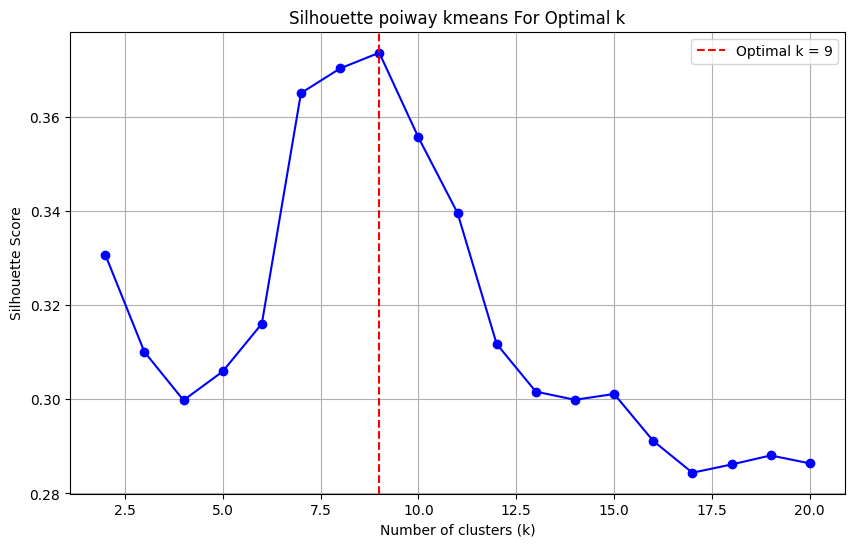

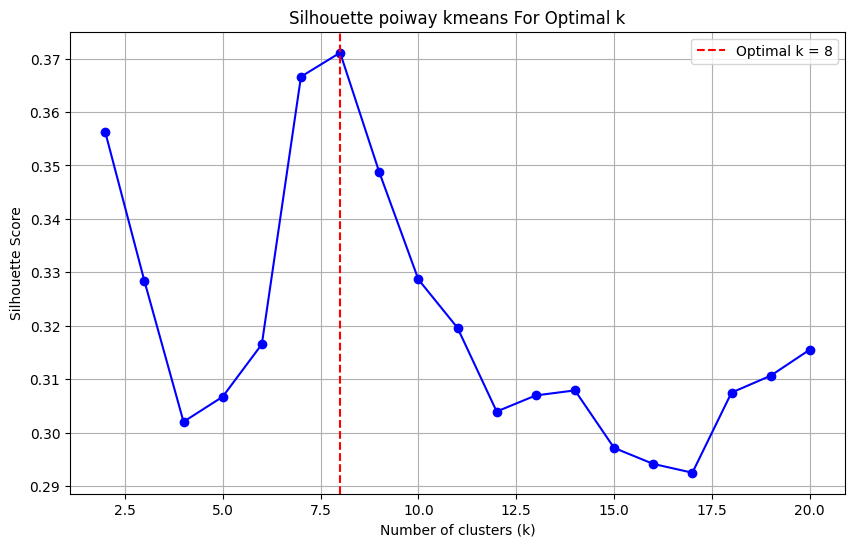

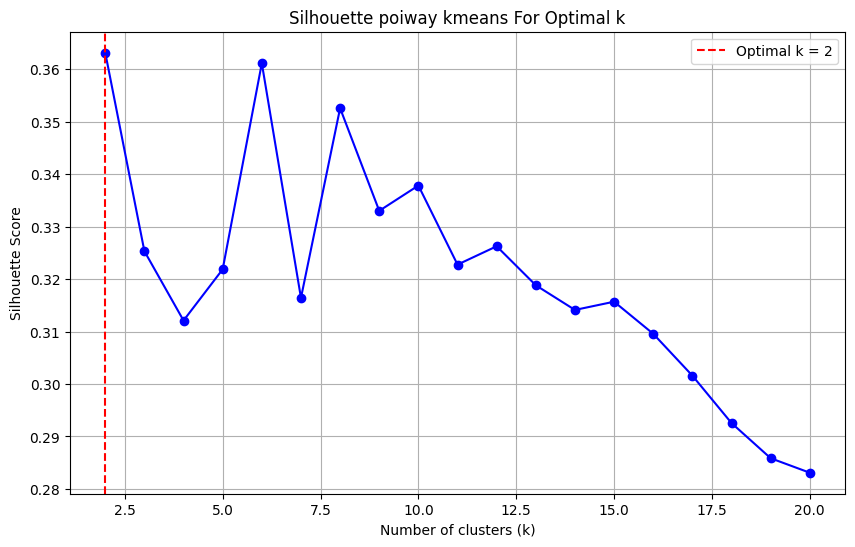

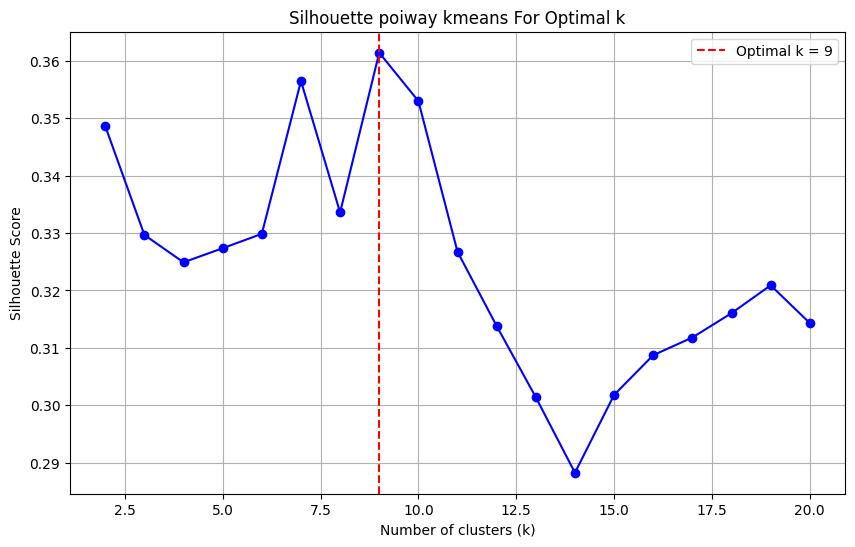

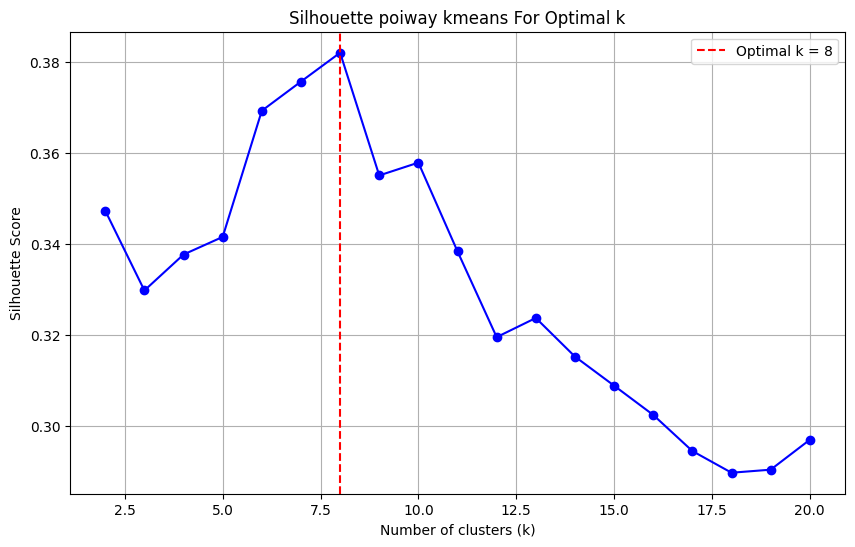

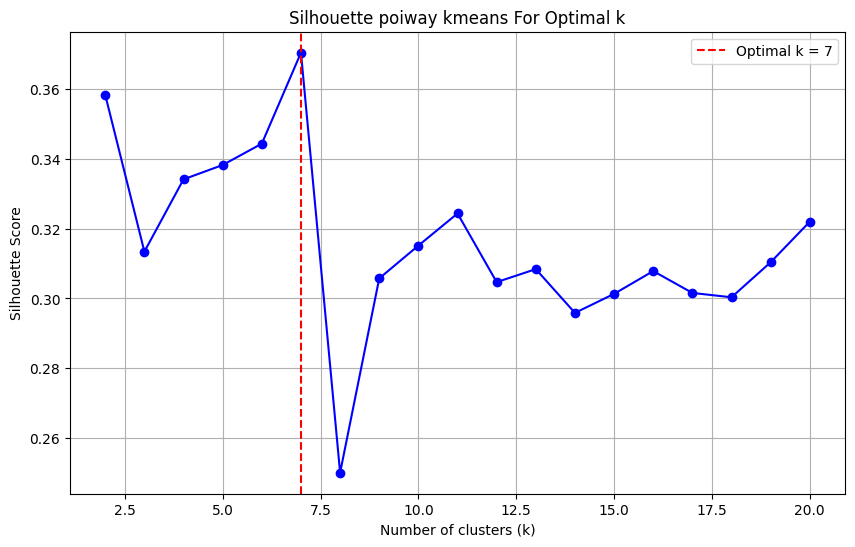

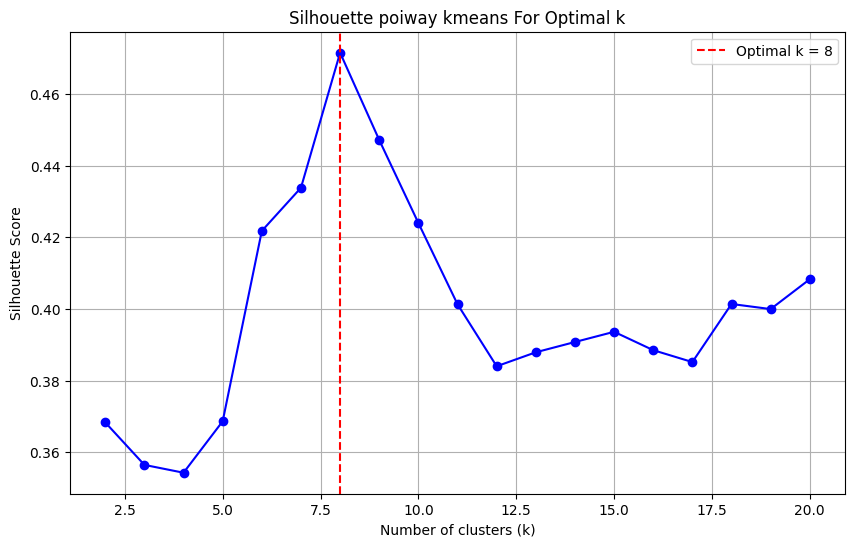

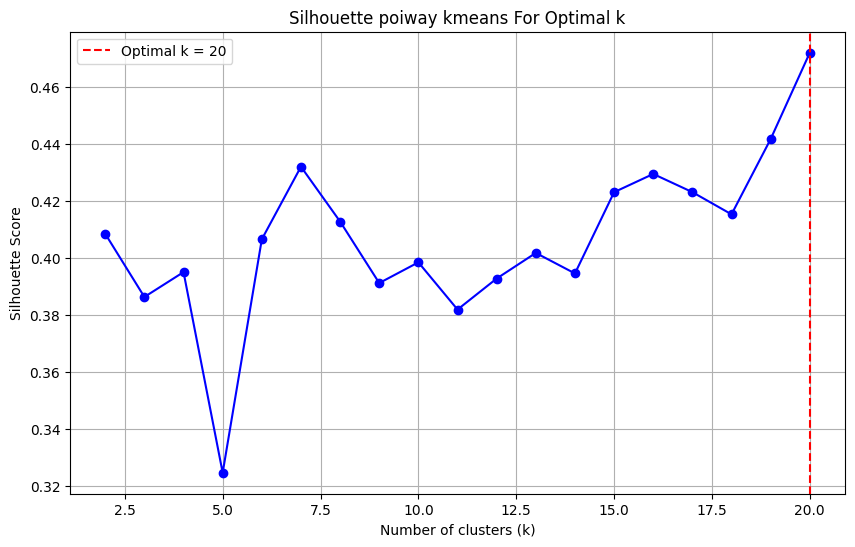

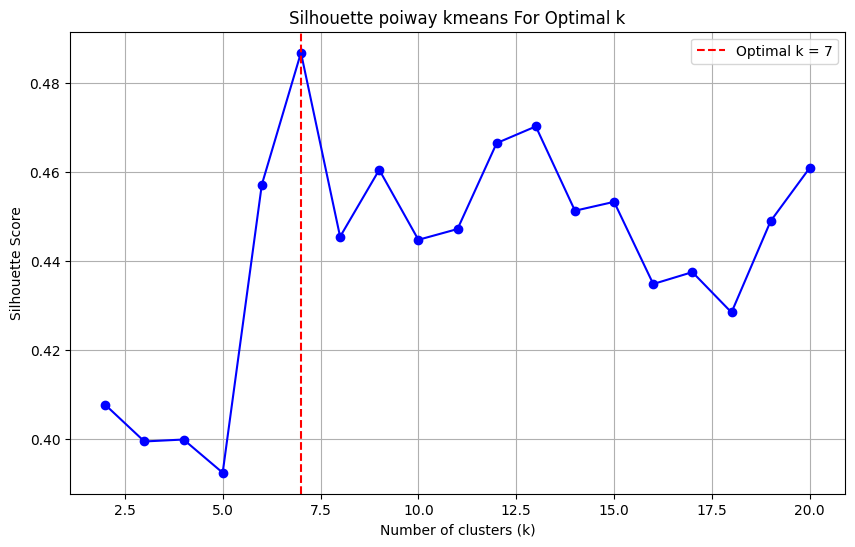

In [46]:
oggetto.transform_data_forencoding(0)

### Esecuzione seconda codifica

2014 calculating silhoette
2014 finish silhoette
2015 calculating silhoette
2015 finish silhoette
2016 calculating silhoette
2016 finish silhoette
2017 calculating silhoette
2017 finish silhoette
2018 calculating silhoette
2018 finish silhoette
2019 calculating silhoette
2019 finish silhoette
2020 calculating silhoette
2020 finish silhoette
2021 calculating silhoette
2021 finish silhoette
2022 calculating silhoette
2022 finish silhoette


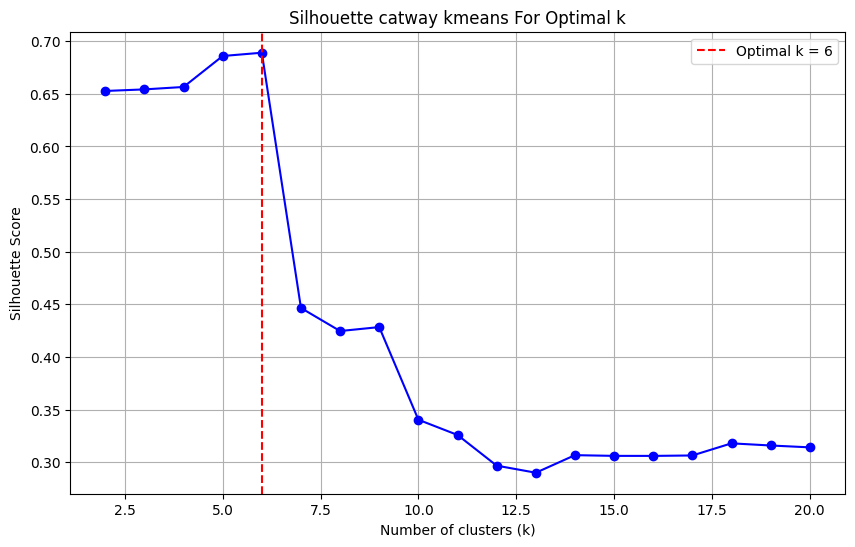

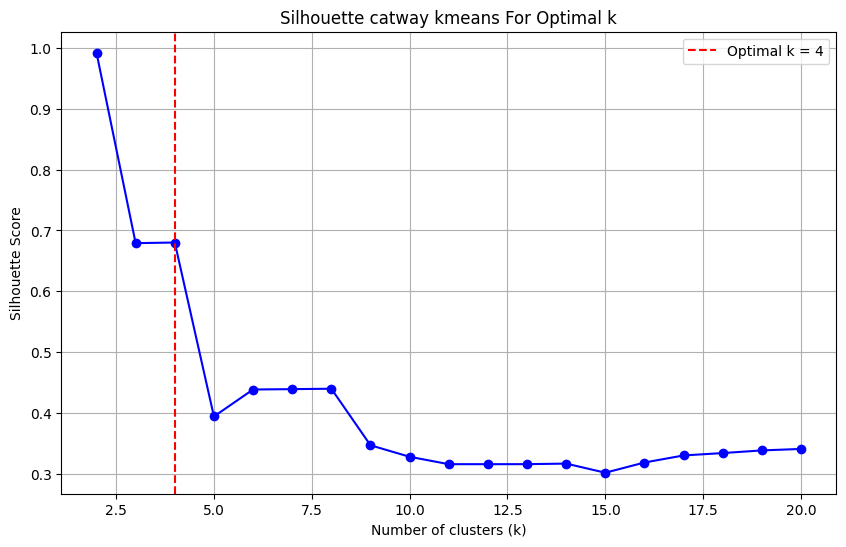

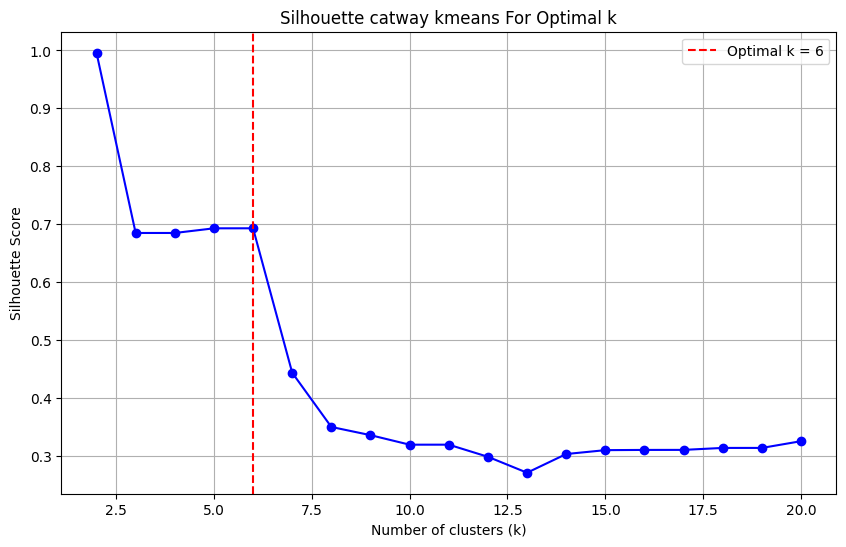

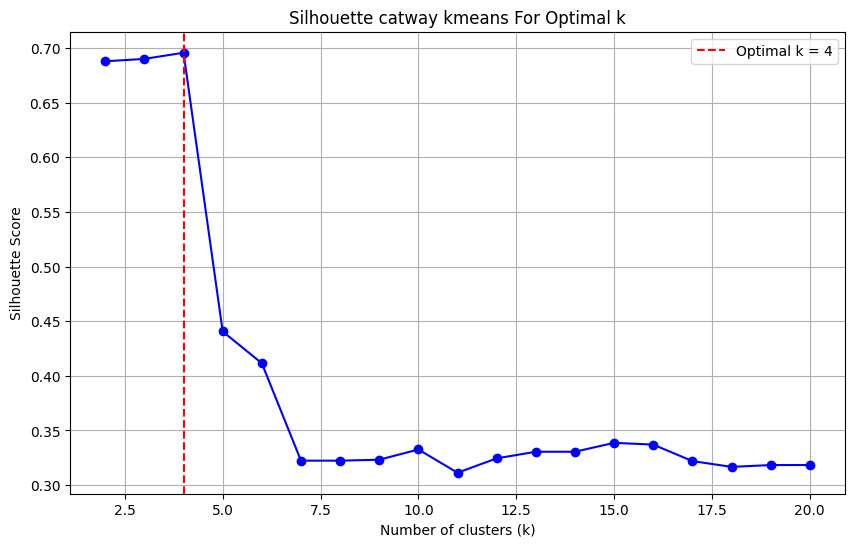

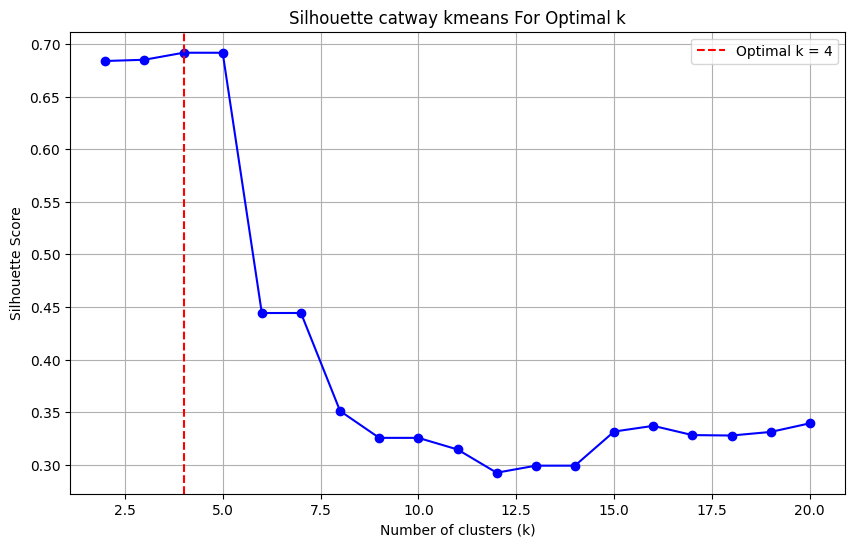

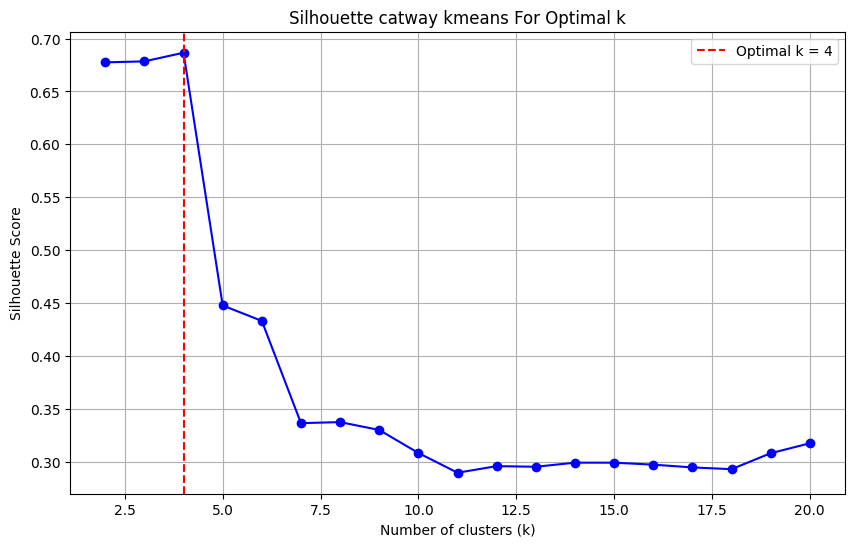

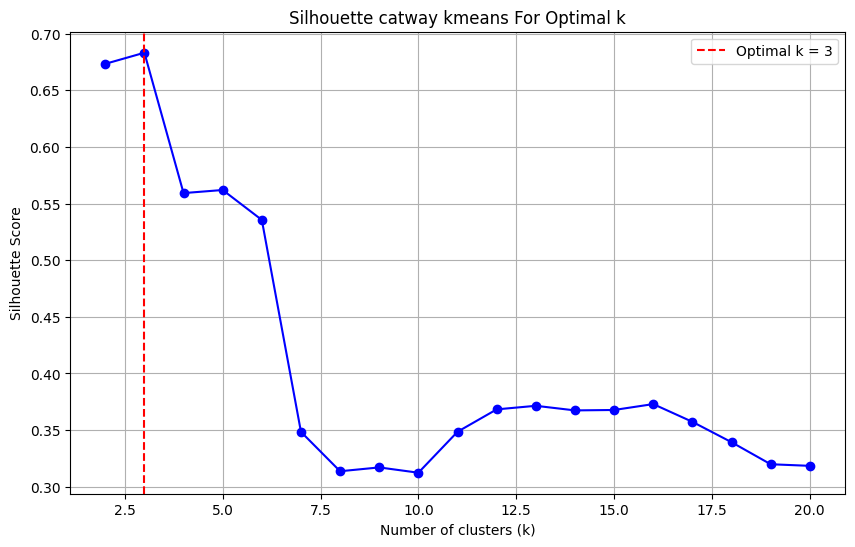

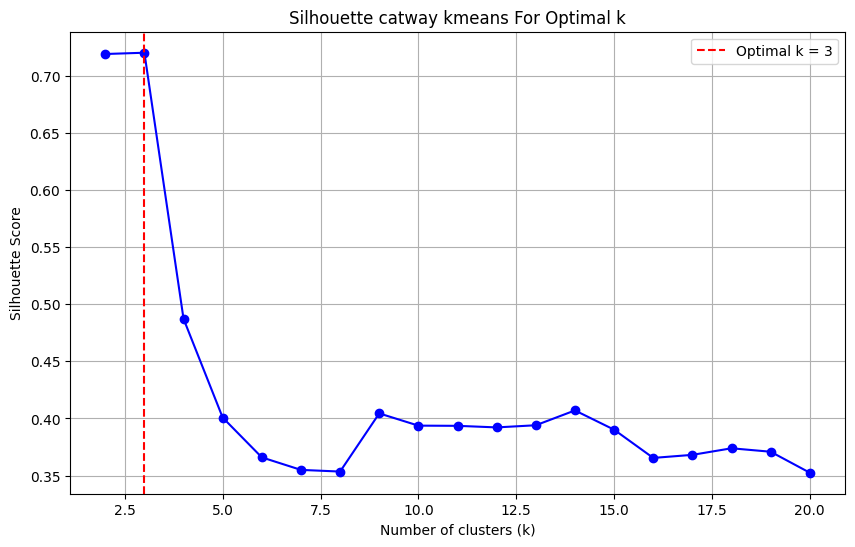

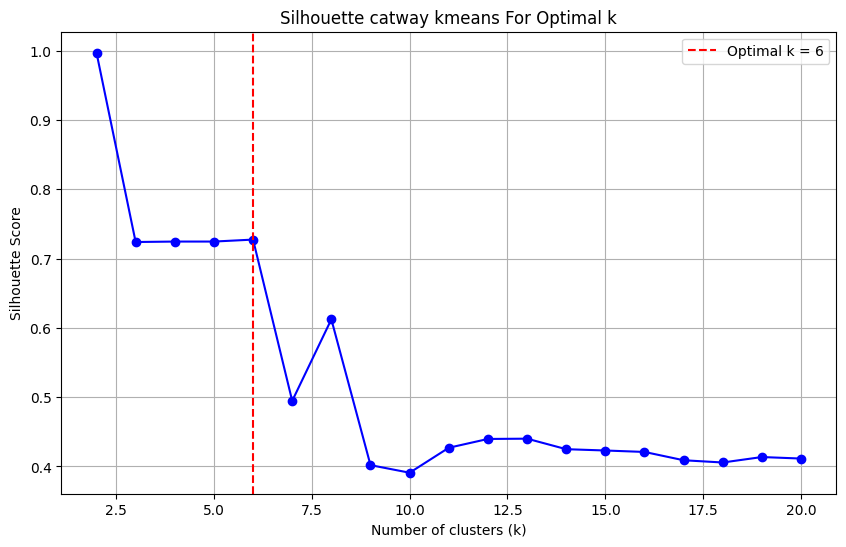

In [47]:
oggetto.transform_data_forencoding(1)

### Esecuzione terza codifica:
delete_files() serve per pulire file creati per la gestione di codice parallelo è importante eseguire pure questo metodo

2014 calculating silhoette
2014 finish silhoette
 min: [0, 8016, 29, 77, 1213, 2212, 125] max: [20, 8016, 66, 114, 1865, 3356, 630] num_tracce[47189, 1, 18055, 5233, 4, 2, 1004]
2015 calculating silhoette
2015 finish silhoette
 min: [0, 2890, 78, 29, 5284, 870, 240] max: [20, 3368, 196, 67, 5806, 1686, 576] num_tracce[49694, 5, 3563, 20126, 3, 8, 20]
2016 calculating silhoette
2016 finish silhoette
 min: [0, 6577, 78, 10078, 29, 477] max: [20, 6577, 337, 10078, 68, 2014] num_tracce[51393, 2, 3585, 1, 23158, 10]
2017 calculating silhoette
2017 finish silhoette
 min: [77, 0, 3128, 30, 2349, 435] max: [191, 21, 4040, 67, 2349, 912] num_tracce[4143, 61466, 4, 25930, 1, 6]
2018 calculating silhoette
2018 finish silhoette
 min: [0, 29, 1014, 76, 3796] max: [20, 68, 2632, 764, 3796] num_tracce[58142, 26290, 4, 4190, 1]
2019 calculating silhoette
2019 finish silhoette
 min: [0, 30, 5612, 78] max: [28, 67, 5612, 816] num_tracce[50730, 24813, 1, 4280]
2020 calculating silhoette
2020 finish silho

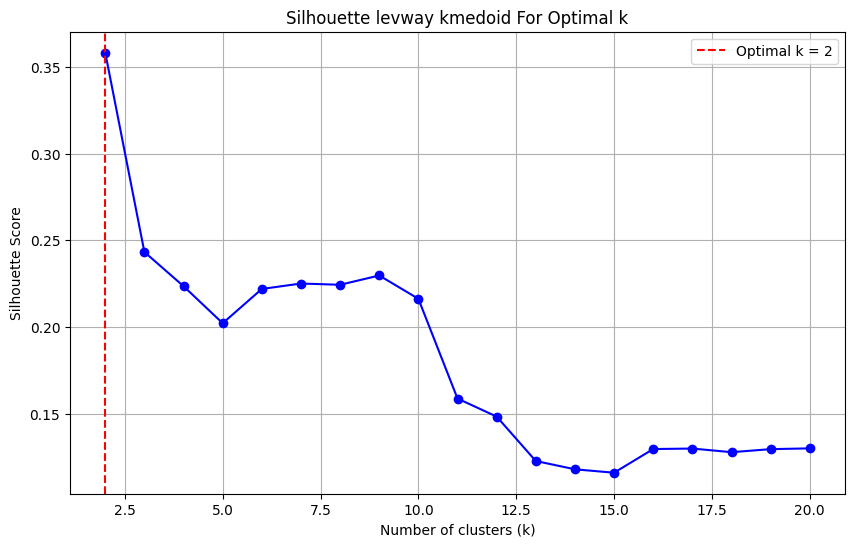

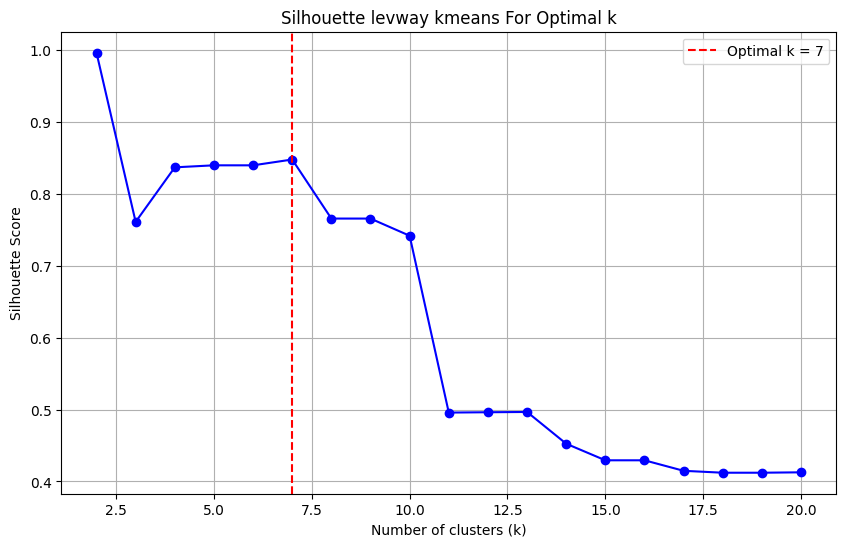

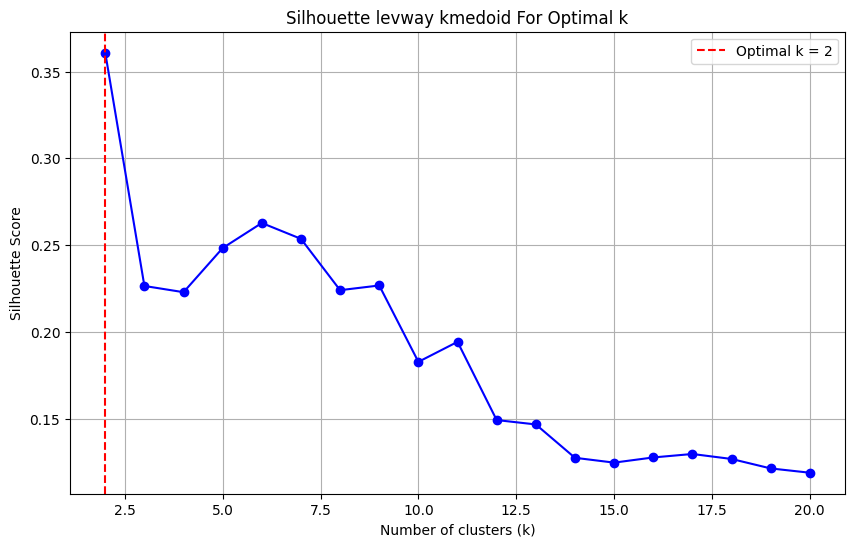

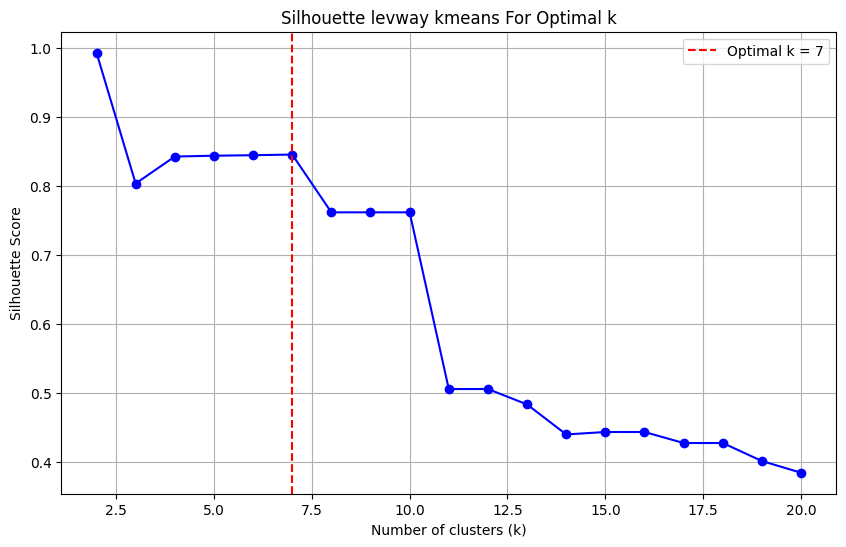

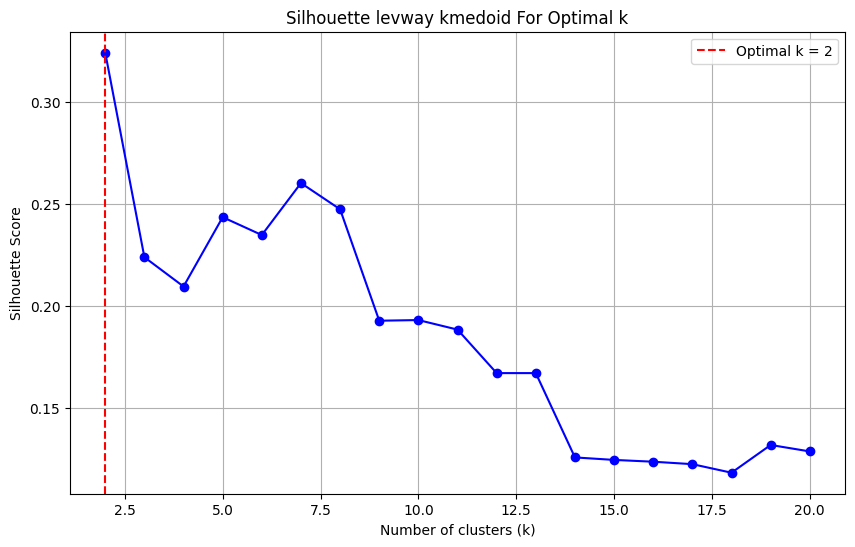

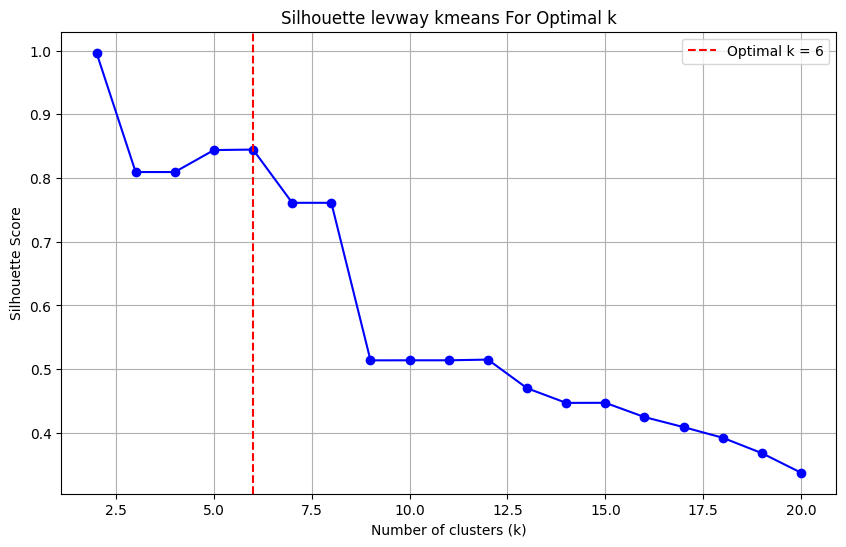

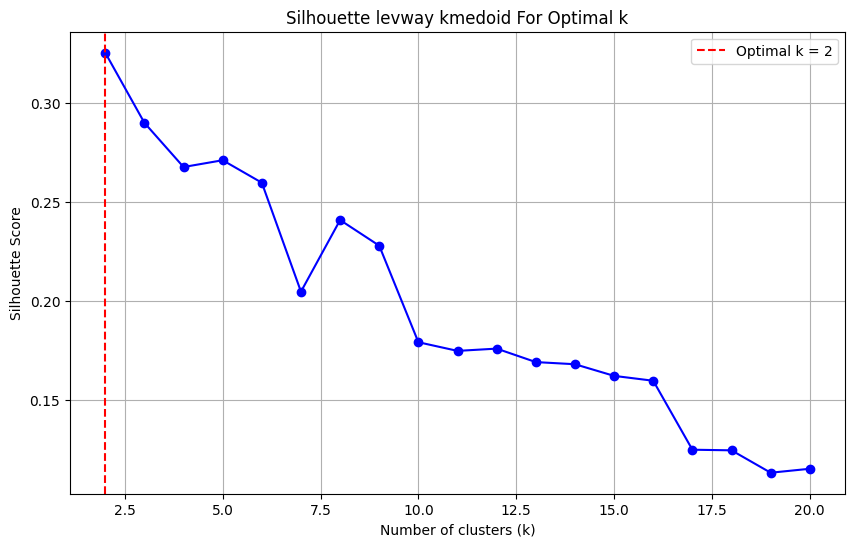

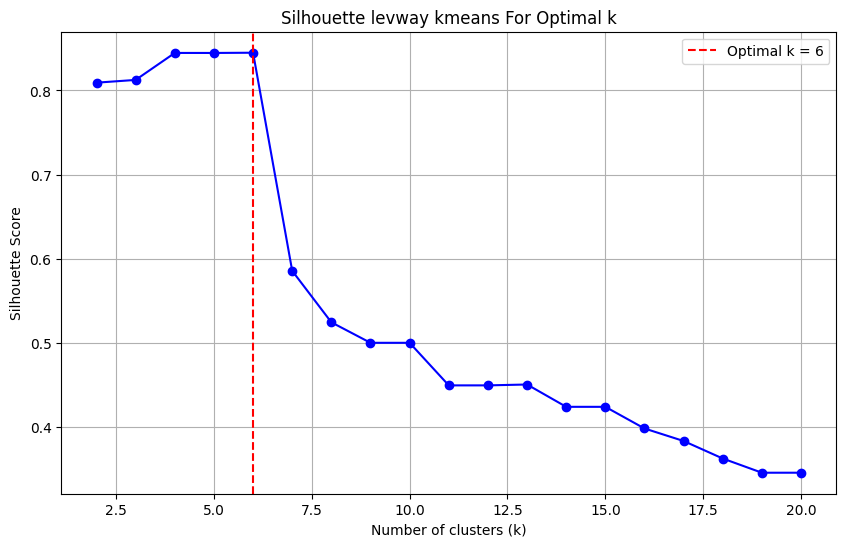

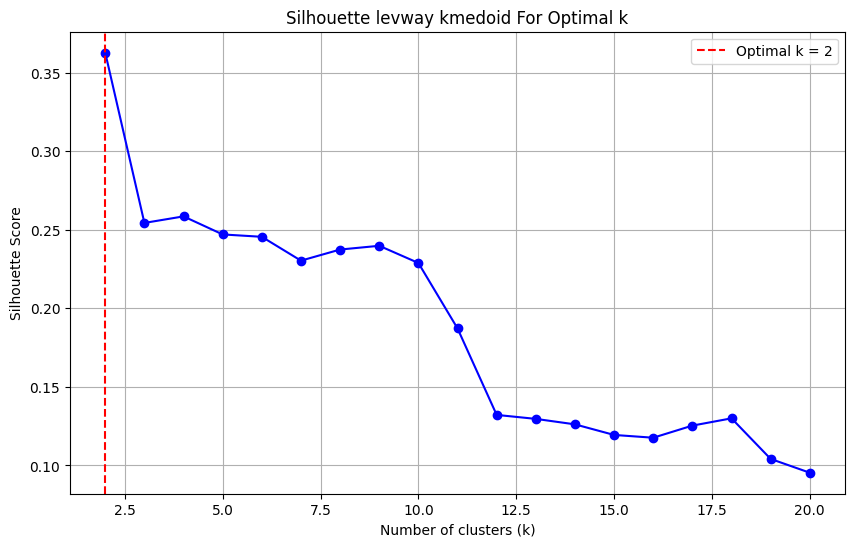

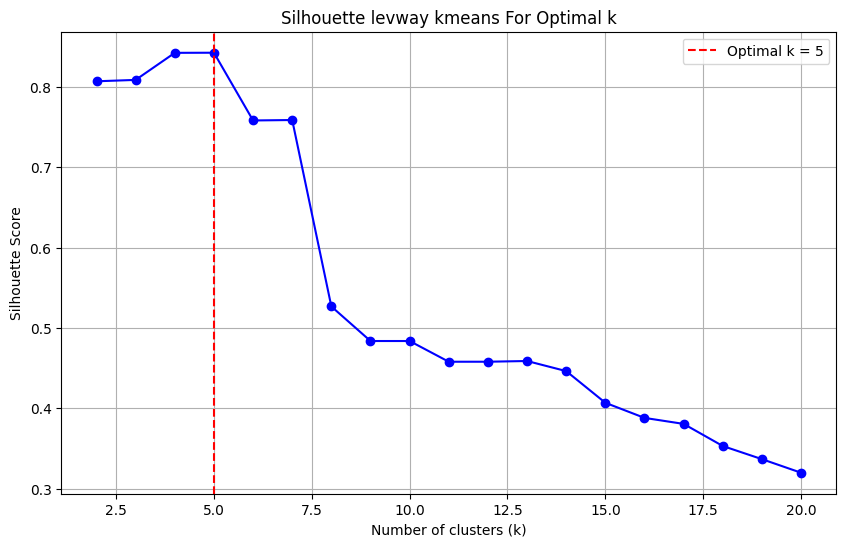

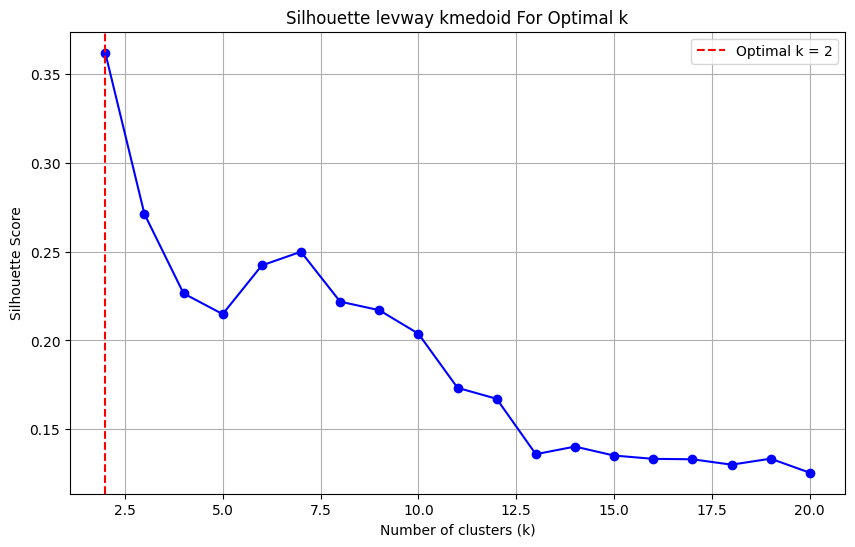

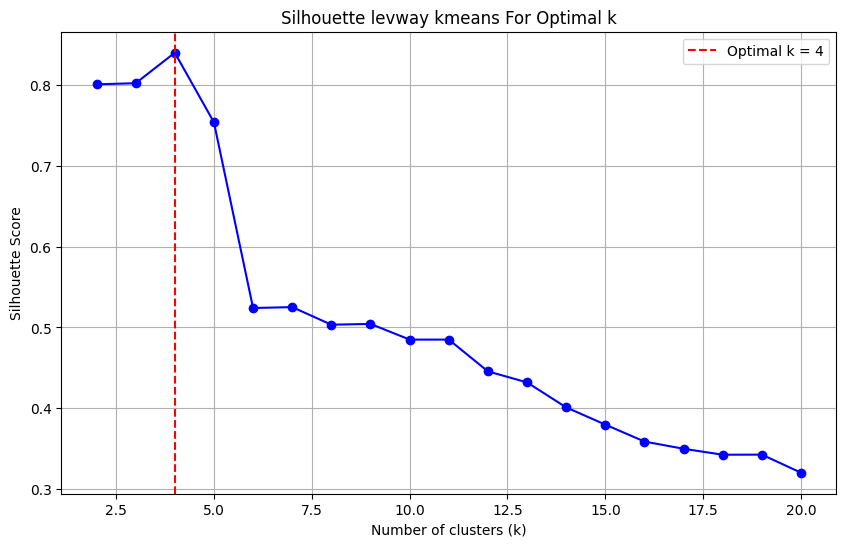

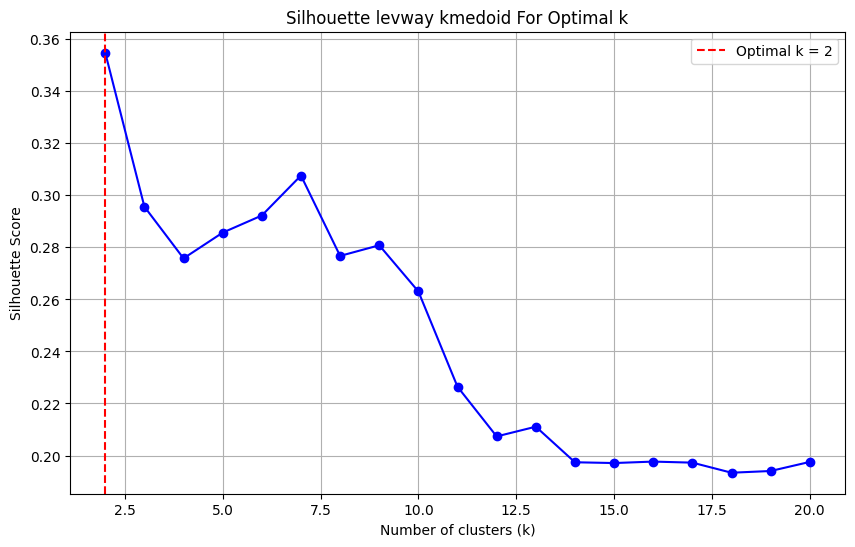

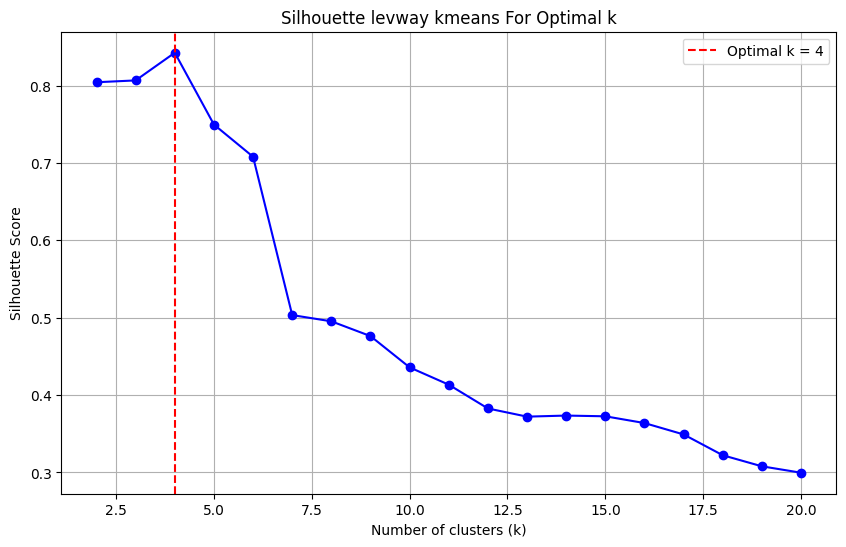

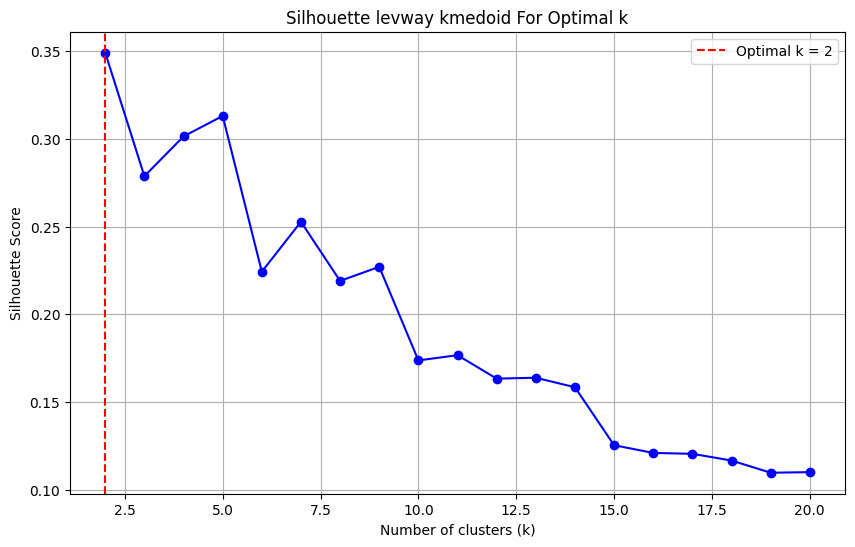

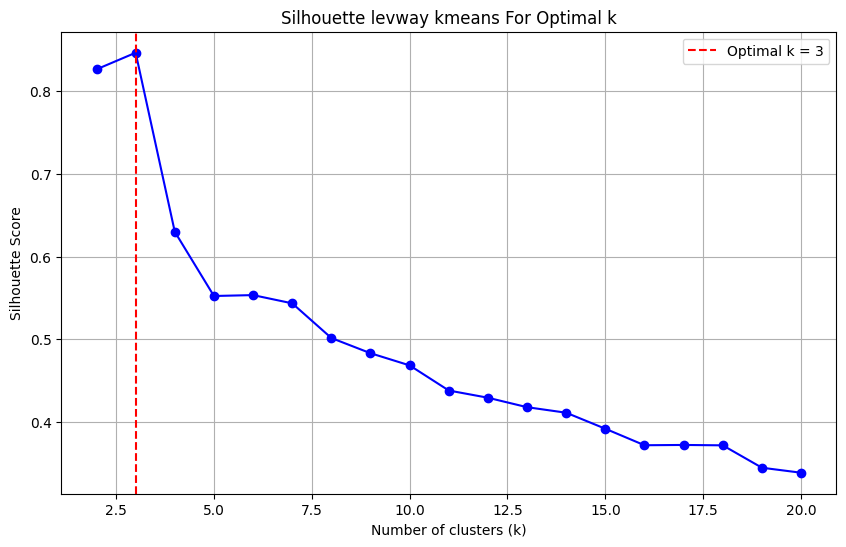

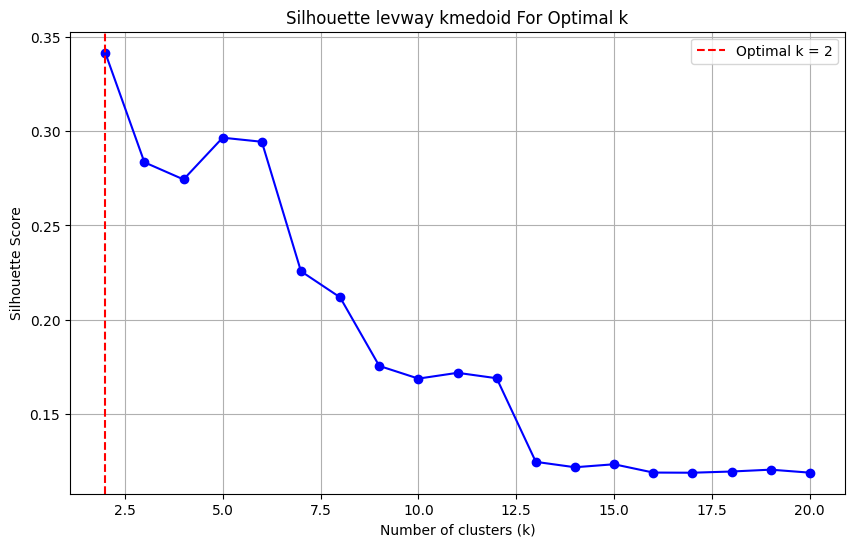

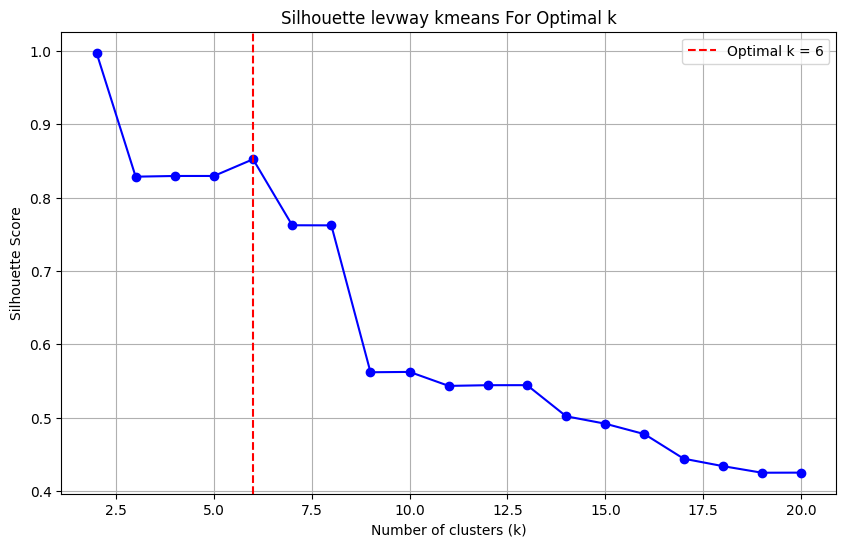

In [45]:
oggetto.transform_data_forencoding(2)
oggetto.delete_files()